## 一、函数定义

### 1. import

In [268]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from stock_centre import *
from scipy.stats import norm
import plotly.express as px
hq = Stock_Data_Centre()
pro = TuShare().pro

### 2. 交易相关

In [2]:
def get_underlying_colse(underlying_code, date, is_today = False, is_index = False):
    '''
    获取指定标的在某日的收盘价/前收盘价
    :param underlying_code: 标的代码（SZ、SH结尾）
    :param date: 指定交易日期
    :param is_today: 是否求当日收盘价，默认否，求昨日
    :param is_index: 标的是否为指数，默认否
    :return: 返回昨日收盘价
    '''
    hq = Stock_Data_Centre()
    pro = TuShare().pro

    if is_index == True:
        underlying_info = hq.get_hq(code=underlying_code, start_date=date.strftime('%Y-%m-%d'),
                                        end_date=date.strftime('%Y-%m-%d'), index_data=True)
    else:
        underlying_info = pd.read_feather('/root/jupyter/jupyter/hq_temp.fea')
        underlying_info['trade_date'] = pd.to_datetime(underlying_info['trade_date'])
        underlying_info = underlying_info[underlying_info['trade_date']==date.strftime('%Y-%m-%d')]
        # underlying_info = pro.fund_daily(ts_code=underlying_code, start_date=date.strftime('%Y%m%d'),
        #                                      end_date=date.strftime('%Y%m%d'))
    # print(underlying_info)
    underlying_info = underlying_info.sort_values(by='trade_date', ascending=True)
    underlying_pre_close = underlying_info['pre_close'].values[0]  # 标的前收盘价
    underlying_today_close = underlying_info['close'].values[0]  # 标的今日收盘价

    if is_today:
        return underlying_today_close
    else:
        return underlying_pre_close


In [264]:
class Trade_Date():
    def __init__(self):
        self.hq = Stock_Data_Centre()
        self.pro = TuShare().pro

    def get_trade_date(self, underlying_code, start_date, end_date, is_index):
        '''
        # 获取某标的的交易日序列
        :param underlying_code: 标的代码, 以'SZ', 'SH'结尾
        :param start_date: 开始日期
        :param end_date: 截止日期
        :param is_index: 标的是否为指数
        :return:
        '''
        if start_date <= end_date:
            if is_index == True:
                underlying_date_info = self.hq.get_hq(code=underlying_code, start_date=start_date.strftime('%Y-%m-%d'),
                                            end_date=end_date.strftime('%Y-%m-%d'), index_data=True)
                return list(underlying_date_info.index)
            else:
                underlying_info = pd.read_feather('/root/jupyter/jupyter/hq_temp.fea')
                underlying_info['trade_date'] = pd.to_datetime(underlying_info['trade_date'])
                underlying_info = underlying_info[(underlying_info['trade_date']>=start_date.strftime('%Y-%m-%d')) & (underlying_info['trade_date']<=end_date.strftime('%Y-%m-%d'))]
                # underlying_date_info = self.pro.fund_daily(ts_code=underlying_code, start_date=start_date.strftime('%Y%m%d'),
                #                                  end_date=end_date.strftime('%Y%m%d'))
                dates = underlying_info['trade_date']
                # dates = underlying_date_info['trade_date']
                return dates.tolist()
        else:
            return []

    def get_trade_date_gap(self, underlying_code, start_date, end_date, is_index):

        date_gap = len(self.get_trade_date(underlying_code, start_date, end_date, is_index))
        
        return date_gap


[4, 3, 2, 1]


(2.5, 15.874507866387544, 1.2909944487358056)

In [307]:
class Opt_Assistant():
    def __init__(self):
        self.hq = Stock_Data_Centre()
        self.opt_info = pd.read_feather(f"{self.hq.data_path}/opt/contract_info_fix.fea")

    def get_opt_code(self, underlying_symbol, exercise_price, contract_type, exercise_ym=None, date=None):
        '''
        获取期权合约代码
        :param underlying_symbol:  标的代码
        :param exercise_price:  行权价格
        :param contract_type:  合约类型。CO-认购期权，PO-认沽期权
        :param exercise_ym:  到期年月（如:2023-08），与date参数二选一
        :param date:  指定日期，返回全部该日期可交易的标的
        :return:
        '''
        temp_info = self.opt_info.query(
            "underlying_symbol==@underlying_symbol and exercise_price==@exercise_price and contract_type==@contract_type")
        if date is not None:
            date = pd.to_datetime(date)
            temp_info = temp_info.query("list_date<=@date<=last_trade_date")
        elif exercise_ym is not None:
            temp_info = temp_info[temp_info['exercise_ym'] == exercise_ym]
        if len(temp_info) > 0:
            return temp_info.code.tolist()
        return []

    def get_gear_info(self, underlying_symbol, contract_type, exercise_ym, ascending=True, date=None):
        '''
        获取期权档位信息
        :param underlying_symbol: 标的代码
        :param contract_type:  合约类型。CO-认购期权，PO-认沽期权
        :param exercise_ym:  到期年月（如:2023-08）
        :param ascending:  是否升序
        :param date:  指定日期，返回全部该日期可交易的标的，不指定则返回全部。建议输入回测日期，否则可能会返回未上市或已退市的合约
        :return:
        '''
        temp_info = self.opt_info.query(
            "underlying_symbol==@underlying_symbol and contract_type==@contract_type and exercise_ym==@exercise_ym")
        if date is not None:
            date = pd.to_datetime(date)
            temp_info = temp_info.query("list_date<=@date<=last_trade_date")
        temp_info = temp_info[['code', 'name', 'underlying_symbol', 'exchange_code', 'contract_type', 'exercise_price', 'expire_date']].reset_index(drop=True).sort_values(['exercise_price'], ascending=ascending)
        return temp_info
    
    def get_opt_info(self, code):
        '''
        已知合约代码，获取其他详细信息
        :param opt_code:  合约代码
        :param date:  指定日期
        :return:
        '''
        temp_info = self.opt_info.query("code==@code")
        temp_info = temp_info[['code', 'name', 'underlying_symbol', 'exchange_code', 'contract_type', 'exercise_price', 'expire_date']].reset_index(drop=True)
        return temp_info
    
    def get_opt_info(self, code):
        '''
        已知合约代码，获取其他详细信息
        :param opt_code:  合约代码
        :param date:  指定日期
        :return:
        '''
        temp_info = self.opt_info.query("code==@code")
        temp_info = temp_info[['code', 'name', 'underlying_symbol', 'exchange_code', 'contract_type', 'exercise_price', 'expire_date']].reset_index(drop=True)
        return temp_info

In [5]:
def code_trans(underlying_code=None, opt_underlying_code=None):
    '''
    实现期权信息表中的标的代码和标的行情表中的代码相互转换
    :param underlying_code: 标的代码（以SH、SZ结尾）
    :param opt_underlying_code: 期权表中标的代码（以XSHG、XSHE结尾）
    :return: 对应的标的代码
    '''
    while opt_underlying_code != None:
        if 'XSHG' in opt_underlying_code:
            return opt_underlying_code[0:7] + 'SH'
        elif 'XSHE' in opt_underlying_code:
            return opt_underlying_code[0:7] + 'SZ'
    
    while underlying_code != None:
        if 'SH' in underlying_code:
            return underlying_code[0:7] + 'XSHG'
        elif 'SZ' in underlying_code:
            return underlying_code[0:7] + 'XSHE'

In [6]:
#['510050.XSHG', 'CO', '2016-01', Timestamp('2016-01-28 00:00:00')]
# opt_ass = Opt_Assistant()
# options = opt_ass.get_gear_info('510050.XSHG', 'CO', exercise_ym='2016-01', ascending=True, date=datetime.date(2016,1,28))
# options.empty

In [7]:
def get_trade_option(opt_underlying_code, date, option_type, underlying_pre_close, n, is_index):
    '''
    选择理想的期权
    :param opt_underlying_code: 期权表对应的标的代码
    :param date: 指定日期
    :param option_type: 认购/认沽，CO-认购期权，PO-认沽期权
    :param underlying_pre_close: 标的前收盘价（当前点位）
    :param n: 虚值和实值的档位，虚（实）值为正（负），如虚（实）一时， n=1（-1）
    :return: 被选期权的合约信息
    '''
    opt_ass = Opt_Assistant()
    date_ass = Trade_Date()

    def trade_month_options(opt_underlying_code, date, option_type, is_index):
        '''
        获取距离当天到期时间最短的期权合约
        :param opt_underlying_code: 期权表对应的标的代码
        :param date: 日期
        :param option_type: 合约类型。CO-认购期权，PO-认沽期权
        :return options
        '''
        
        underlying_code = code_trans(opt_underlying_code = opt_underlying_code)
        now_date = date.strftime("%Y-%m")  # 当月合约
        flag = False

        while not flag:
            # print([opt_underlying_code, option_type, now_date, date])
            options = opt_ass.get_gear_info(opt_underlying_code, option_type, exercise_ym=now_date, ascending=True, date=date)
            # print(options)
            if options.empty == False:
                last_date = options['expire_date'].iloc[0]
                duration = date_ass.get_trade_date_gap(underlying_code, date, last_date, is_index=is_index)
                # duration = (last_date - date).days
                if duration > 7:
                    flag = True
                else:
                    now_date = (date + relativedelta(months=1)).strftime("%Y-%m")  # 距离不足7天则到下月合约
            else:
                now_date = (date + relativedelta(months=1)).strftime("%Y-%m")  # 无可选当月合约则到下月合约

        return options

    trade_month_options = trade_month_options(opt_underlying_code, date, option_type, is_index)

    if option_type == 'CO':
        option_type = 1
    elif option_type == 'PO':
        option_type = -1

    def trade_strike_option(trade_month_options, underlying_pre_close, option_type, n):
        '''
        获取最终的交易期权(选择行权价)
        :param trade_month_options: 可交易的期权合集（DataFrame）
        :param underlying_pre_price: 昨日收盘价格
        :param option_type: 看涨为1，看跌为-1
        :param n: 虚值和实值的档位，虚（实）值为正（负），如虚（实）一时， n=1（-1）
        :return: strike_price, 对应的交易期权
        '''
        # print(trade_month_options['exercise_price'], underlying_pre_close)
        if n * option_type > 0:  # 看涨期权的虚值、看跌期权的实值往上取
            trade_strike_option = trade_month_options[trade_month_options['exercise_price'] 
                                               > underlying_pre_close].iloc[abs(n) - 1]
        elif n * option_type < 0:  # 看涨期权的虚值、看跌期权的实值往下取
            trade_strike_option = trade_month_options[trade_month_options['exercise_price'] 
                                               < underlying_pre_close].iloc[-abs(n)]

        trade_strike_option = trade_strike_option.to_frame()

        return trade_strike_option
    
    trade_option = trade_strike_option(trade_month_options, underlying_pre_close, option_type, n)
    
    return trade_option.iloc[:,0]

In [310]:
# pd.read_feather(f"{hq.data_path}/quotation/opt/1d/{date.strftime('%Y-%m-%d')}.fea")

In [9]:
def trade_money(opt_info, date, trade_direction):
    '''
    求买卖一手期权的收入/成本（含手续费）
    :param opt_info: 拟购买的期权合约信息，由strike_price函数给出，格式为series
    :param date: 购买日期
    :param trade_direction: 交易方向，买（卖）为 1（-1）
    :return: 购买一手期权需要的成本/收入，含手续费
    '''

    # 1. 求当日合约价格
    # hq = Stock_Data_Centre()
    opt_quotation_info = pd.read_feather(f"{hq.data_path}/quotation/opt/1d/{date.strftime('%Y-%m-%d')}.fea")
    trade_option = opt_quotation_info[opt_quotation_info['code'] == opt_info.values[0]]
    opt_close_price = trade_option['settle_price'].values
    # print(opt_close_price)
    
    # 2. 求合约手续费/规格
    if opt_info.values[2] in ['000852.XSHG', '000300.XSHG', '000016.XSHG']: # 中证1000、沪深300、上证50
        handling_fee = 15
        commission = 15*3
        total_fee = handling_fee + commission
        multiplier = 100 # 合约乘数
    elif opt_info.values[2] in ['159915.XSHE', '159919.XSHE', '159922.XSHE', '159901.XSHE']:
        # 深交所：创业板ETF、沪深300ETF、中证500ETF、深证100ETF
        handling_fee = 1.6
        commission = 5
        total_fee = handling_fee + commission
        multiplier = 10000 # 合约乘数
    elif opt_info.values[2] in ['510050.XSHG', '510300.XSHG', '510500.XSHG', '588000.XSHG', '588080.XSHG']:
        # 上交所：上证50ETF、沪深300ETF、中证500ETF、科创50ETF、科创板50ETF
        handling_fee = 1.6
        commission = 5
        total_fee = handling_fee + commission
        multiplier = 10000 # 合约乘数
    
    # 3. 购买一手期权的总费用/收入
    trade_money = opt_close_price * multiplier + trade_direction * total_fee
    
    return trade_money[0]

In [10]:
def bail(trade_option, is_index, date, action_flag, bail_adjust = 0.12, min_bail = 0.5):
    '''
    求一手期权保证金水平
    :param opt_info: 拟交易的期权合约信息，由strike_price函数给出，格式为series
    :param is_index: 是否为指数，是True，否False
    :param date: 交易日期
    :param action_flag: 开仓保证金(交易/维持保证金), action_flag=1(action_flag=-1)
    :param bail_adjust: 保证金调整系数，默认12%，主要是中金所的保证金调整系数有可能会不定期调整
    :param min_bail: 最低保障系数，默认0.5，主要是中金所的保证金调整系数有可能会不定期调整
    :return: 返回开仓保证金水平、当日的交易/维持保证金水平 (list格式)
    '''

    hq = Stock_Data_Centre()
    pro = TuShare().pro
    underlying_code = code_trans(underlying_code=None, opt_underlying_code=trade_option.values[2])
    opt_quotation_info = pd.read_feather(f"{hq.data_path}/quotation/opt/1d/{date.strftime('%Y-%m-%d')}.fea")
    # q2 = opt_quotation_info[opt_quotation_info['code']=='10000482.XSHG']
    # print("="*20)
    # print(q2)
#     df_2 = pd.read_feather(f"{hq.data_path}/quotation/opt/1d/2016-01-04.fea")
#     df_2[df_2['code']=='10000482.XSHG']
    
    if 'CO' in trade_option.values:
        opt_type = 1 # 认购期权
    elif 'PO' in trade_option.values:
        opt_type = -1 # 认沽期权

    # 1. 标的价格信息
    underlying_pre_close = get_underlying_colse(underlying_code, date, is_today = False, is_index = is_index)
    underlying_today_close = get_underlying_colse(underlying_code, date, is_today = True, is_index = is_index)
    
    # print(type(underlying_pre_close))
    
    # 2. 期权价格信息
    # print(date, opt_quotation_info['code'], trade_option)
    trade_option_choose = opt_quotation_info[opt_quotation_info['code'] == trade_option.values[0]]
    # print(trade_option_choose['pre_settle'].values[0])
    opt_pre_settle = trade_option_choose['pre_settle'].values[0] # 期权前结算价
    opt_today_settle = trade_option_choose['settle_price'].values[0] # 期权当日结算价
    strike_price = trade_option.values[5]

    # 3. 期权虚值额 = max(行权价 - 标的当日收盘价, 0) * opt_type
    virtual_pre_value = np.max(strike_price - underlying_pre_close, 0) * opt_type
    virtual_today_value = np.max(strike_price - underlying_today_close, 0) * opt_type

    # 4. 计算保证金
    # 4.1 确认数据：开仓用前结算价/收盘价，交易/维持用当日的
    underlying_price = (action_flag > 0) * underlying_pre_close + (action_flag < 0) * underlying_today_close
    opt_price = (action_flag > 0) * opt_pre_settle + (action_flag < 0) * opt_today_settle
    virtual_value = (action_flag > 0) * virtual_pre_value + (action_flag < 0) * virtual_today_value

    # print(underlying_price, opt_price, virtual_value)
    # print(type(underlying_price), type(opt_price), type(virtual_value))
    # 4.2 计算保证金
    if trade_option.values[3] == 'CCFX': # 中金所
        if opt_type == 1:
        # 每手看涨期权保证金=合约乘数*(合约结算价+max(标的收盘价×合约保证金调整系数-虚值额，
                                                # 最低保障系数×标的收盘价×合约保证金调整系数))
            bail = 100 * (opt_price + max(underlying_price * bail_adjust - virtual_value,
                                                    min_bail * underlying_price * bail_adjust))
        elif opt_type == -1:
        # 每手看跌期权保证金=合约乘数*(合约结算价+max(标的收盘价×合约保证金调整系数-虚值额，
                                                # 最低保障系数×合约行权价格×合约保证金调整系数）
            bail = 100 * (opt_price + max(underlying_price * bail_adjust - virtual_value,
                                                    min_bail * strike_price * bail_adjust))
    elif trade_option.values[3] in ['XSHE', 'XSHG']: # 上交所和深交所
        if opt_type == 1:
            # 认购期权义务仓保证金＝[合约结算价+Max(12%×标的收盘价-认购期权虚值, 7%×标的收盘价)]×合约单位
            bail = 10000 * (opt_price + max(0.12 * underlying_price - virtual_value, 0.07 * underlying_price))
        elif opt_type == -1:
            # 认沽期权义务仓保证金＝Min[合约结算价+Max(12%×合约标的收盘价-认沽期权虚值，7%×行权价), 行权价]×合约单位
            bail = 10000 * min(opt_price + max(0.12 * underlying_price-virtual_value, 0.07 * strike_price), strike_price)

    return bail

#### 逻辑一：按保证金走

In [11]:
def get_daily_record(underlying_code, date, end_date, trade_direction, option_type, is_index, initial_cash,
                     buffer, is_reinvest, n, hold_record=None, bail_adjust=0.12, min_bail=0.5):
    '''
    获取每日的交易情况、计算盈亏、保证金等账户情况
    :param underlying_code: 标的代码, 以'SZ', 'SH'结尾
    :param date: 当日日期
    :param end_date: 回测截止日期
    :param trade_direction: 交易方向
    :param option_type: 认购'CO', 认沽'PO'
    :param is_index: 标的是否为指数
    :param initial_cash: 初始资金
    :param buffer: 保证金上浮比例
    :param is_reinvest: 是否再投资, 保证金账户保持不变为0, 将多余的保证金进行再投资则为1
    :param n: 虚值和实值的档位，虚（实）值为正（负）, 如虚（实）一时， n=1（-1）
    :param hold_record: 当日开盘前的账户记录
    :param bail_adjust: 保证金调整系数
    :param min_bail: 最低保障系数
    :return: daily_record
    '''
    flag = True # 平仓后账户余额是否为0
    initial_cash_upset = initial_cash
    hq = Stock_Data_Centre()
    pro = TuShare().pro
    date_ass = Trade_Date()
    opt_quotation_info = pd.read_feather(f"{hq.data_path}/quotation/opt/1d/{date.strftime('%Y-%m-%d')}.fea")

    opt_underlying_code = code_trans(underlying_code=underlying_code)
    underlying_pre_close = get_underlying_colse(underlying_code, date, is_today=False, is_index=is_index)
    underlying_today_close = get_underlying_colse(underlying_code, date, is_today=True, is_index=is_index)
    daily_record = None
    
    if hold_record == None: # 说明今天是回测起始日，尚未开仓
        margin_account = 0
        accum_hold_profit_loss = 0
        account_all = 0
        # 开仓，找出对应的期权
        trade_option = get_trade_option(opt_underlying_code, date, option_type, underlying_pre_close, n, is_index)
        # 计算每手所需的开仓保证金，及当日的交易保证金水平
        # print(trade_option)
        per_open_bail = bail(trade_option, is_index, date, action_flag=1, bail_adjust=bail_adjust, min_bail=min_bail)
        per_trade_bail = bail(trade_option, is_index, date, action_flag=-1, bail_adjust=bail_adjust, min_bail=min_bail)
        # 计算开仓手数
        trade_amount = math.floor(initial_cash / (per_open_bail * (1+buffer)))
        # 计算该期权的结算情况
        # trade_money = trade_money(trade_option, date, trade_direction) * trade_amount
        trade_option_choose = opt_quotation_info[opt_quotation_info['code'] == trade_option.values[0]]
        opt_pre_settle = trade_option_choose['pre_settle'].values[0]  # 期权前结算价
        opt_today_settle = trade_option_choose['settle_price'].values[0]  # 期权当日结算价
        # 更新账户情况
        hold_option = trade_option # 当前持有的期权
        hold_option_amount = trade_amount # 当前持有的期权合约数量
        opt_remain_term = date_ass.get_trade_date_gap(underlying_code, date, hold_option.values[-1], is_index) # 当前期权剩余期限
        trade_money = trade_money(trade_option, date, trade_direction) * trade_amount # 开仓损益
        today_hold_profit_loss = (opt_pre_settle - opt_today_settle) * trade_amount # 今日持仓盈亏
        accum_hold_profit_loss = accum_hold_profit_loss + today_hold_profit_loss # 累积持仓盈亏
        margin_account = max(today_hold_profit_loss + trade_money + per_open_bail * trade_amount, per_trade_bail * trade_amount)
        additional_cash = initial_cash - trade_amount * max(per_trade_bail, per_open_bail)
        account_all = margin_account + additional_cash
        daily_record = [date, hold_option, hold_option_amount, opt_remain_term, trade_money, today_hold_profit_loss,
                        accum_hold_profit_loss, margin_account, additional_cash, initial_cash_upset,
                        account_all, flag]
    else: # 非第一天
        hold_option = hold_record[1]
        hold_option_amount = hold_record[2]
        opt_remain_term = date_ass.get_trade_date_gap(underlying_code, date, hold_option.values[-1], is_index) # 当前期权剩余期限
        # print(date_ass.get_trade_date(underlying_code, date, hold_option.values[-1], is_index))
        accum_hold_profit_loss = hold_record[5]
        margin_account = hold_record[6]
        additional_cash = hold_record[7]
        backtest_remain_term = date_ass.get_trade_date_gap(underlying_code, date, end_date, is_index) # 回测剩余期限
        # print(hold_option.values[-1], opt_remain_term, backtest_remain_term)
        if (opt_remain_term > 7) and (backtest_remain_term > 1): #无需交易，只更新持仓情况
            # 计算该期权的结算情况
            per_trade_bail = bail(hold_option, is_index, date, action_flag=-1, bail_adjust=bail_adjust,
                                  min_bail=min_bail) # 今日交易保证金
            hold_option_choose = opt_quotation_info[opt_quotation_info['code'] == hold_option.values[0]]
            opt_pre_settle = hold_option_choose['pre_settle'].values[0]  # 期权前结算价
            opt_today_settle = hold_option_choose['settle_price'].values[0]  # 期权当日结算价
            today_hold_profit_loss = (opt_pre_settle - opt_today_settle) * hold_option_amount # 今日持仓盈亏
            accum_hold_profit_loss = accum_hold_profit_loss + today_hold_profit_loss  # 累积持仓盈亏
            additional_cash = additional_cash - max(
                per_trade_bail * hold_option_amount - today_hold_profit_loss - margin_account, 0)
            margin_account = max(today_hold_profit_loss + margin_account, per_trade_bail * hold_option_amount)
            account_all = margin_account + additional_cash
            daily_record = [date, hold_option, hold_option_amount, opt_remain_term, today_hold_profit_loss,
                            accum_hold_profit_loss, margin_account, additional_cash, initial_cash_upset,
                            account_all, flag]
        elif ((opt_remain_term == 7) and (backtest_remain_term <= 7)) \
                or ((opt_remain_term > 7) and (backtest_remain_term <= 1)): # 平仓且不再展期
            # 先买入平仓（用昨日结算价）
            hold_option_choose = opt_quotation_info[opt_quotation_info['code'] == hold_option.values[0]]
            opt_pre_settle = hold_option_choose['pre_settle'].values[0]  # 期权前结算价
            close_position_cost = hold_option_amount * opt_pre_settle
            # 计算账户余额
            account_all = margin_account + additional_cash - close_position_cost
            # 更新账户情况
            hold_option = pd.Series([0,0,0, date])  # 当前持有的期权
            hold_option_amount = 0  # 当前持有的期权合约数量
            opt_remain_term = 0
            today_hold_profit_loss = 0
            accum_hold_profit_loss = 0
            margin_account = 0
            additional_cash = account_all
            daily_record = [date, hold_option, hold_option_amount, opt_remain_term, today_hold_profit_loss,
                            accum_hold_profit_loss, margin_account, additional_cash, initial_cash_upset,
                            account_all, flag]
        elif (opt_remain_term == 7) and (backtest_remain_term > 7): # 还剩7个交易日的时候需要展期
            # 先买入平仓（用昨日结算价）
            hold_option_choose = opt_quotation_info[opt_quotation_info['code'] == hold_option.values[0]]
            opt_pre_settle = hold_option_choose['pre_settle'].values[0]  # 期权前结算价
            close_position_cost = hold_option_amount * opt_pre_settle
            # 计算账户余额
            account_all = margin_account + additional_cash - close_position_cost
            # 选择展期合约
            trade_option = get_trade_option(opt_underlying_code, date, option_type, underlying_pre_close, n, is_index)
            # 计算每手所需的开仓保证金，及当日的交易保证金水平
            per_open_bail = bail(trade_option, is_index, date, action_flag=1, bail_adjust=bail_adjust,
                                 min_bail=min_bail)
            per_trade_bail = bail(trade_option, is_index, date, action_flag=-1, bail_adjust=bail_adjust,
                                  min_bail=min_bail)
            if is_reinvest == 1:  # 展期当天会用account_all计算重新开仓的数量
                # 计算开仓手数
                trade_amount = math.floor(account_all / (per_open_bail * (1 + buffer)))
                if trade_amount > 0:
                    # 计算该期权的结算情况
                    trade_option_choose = opt_quotation_info[opt_quotation_info['code'] == trade_option.values[0]]
                    opt_pre_settle = trade_option_choose['pre_settle'].values[0]  # 期权前结算价
                    opt_today_settle = trade_option_choose['settle_price'].values[0]  # 期权当日结算价
                    # 更新账户情况
                    hold_option = trade_option  # 当前持有的期权
                    hold_option_amount = trade_amount  # 当前持有的期权合约数量
                    opt_remain_term = date_ass.get_trade_date_gap(underlying_code, date, hold_option.values[-1],
                                                                  is_index)  # 当前期权剩余期限
                    today_hold_profit_loss = (opt_pre_settle - opt_today_settle) * trade_amount  # 今日持仓盈亏
                    accum_hold_profit_loss = accum_hold_profit_loss + today_hold_profit_loss  # 累积持仓盈亏
                    margin_account = max(today_hold_profit_loss + per_open_bail * trade_amount,
                                         per_trade_bail * trade_amount)
                    additional_cash = account_all - trade_amount * max(per_trade_bail, per_open_bail)
                    account_all = margin_account + additional_cash
                    daily_record = [date, hold_option, hold_option_amount, opt_remain_term, today_hold_profit_loss,
                                    accum_hold_profit_loss, margin_account, additional_cash, initial_cash_upset,
                                    account_all, flag]
                else:
                    flag = False
                    daily_record = [date, None, 0, 0, 0, 0, 0, 0, close_position_cost, account_all, flag]
                    print('平仓后账户余额为0')
            elif is_reinvest == 0: # 每次展期均建立相同的仓位水平，即初始资金
                # 计算开仓手数
                trade_amount = math.floor(initial_cash / (per_open_bail * (1 + buffer)))
                # 计算该期权的结算情况
                trade_option_choose = opt_quotation_info[opt_quotation_info['code'] == trade_option.values[0]]
                opt_pre_settle = trade_option_choose['pre_settle'].values[0]  # 期权前结算价
                opt_today_settle = trade_option_choose['settle_price'].values[0]  # 期权当日结算价
                # 更新账户情况
                hold_option = trade_option  # 当前持有的期权
                hold_option_amount = trade_amount  # 当前持有的期权合约数量
                opt_remain_term = date_ass.get_trade_date_gap(underlying_code, date, hold_option.values[-1],
                                                              is_index)  # 当前期权剩余期限
                today_hold_profit_loss = (opt_pre_settle - opt_today_settle) * trade_amount  # 今日持仓盈亏
                accum_hold_profit_loss = accum_hold_profit_loss + today_hold_profit_loss  # 累积持仓盈亏
                margin_account = max(today_hold_profit_loss + per_open_bail * trade_amount,
                                     per_trade_bail * trade_amount)
                additional_cash = max(account_all, initial_cash) - trade_amount * max(per_trade_bail, per_open_bail)
                initial_cash_upset = initial_cash_upset + max(initial_cash - account_all, 0)
                account_all = margin_account + additional_cash
                daily_record = [date, hold_option, hold_option_amount, opt_remain_term, today_hold_profit_loss,
                                    accum_hold_profit_loss, margin_account, additional_cash, initial_cash_upset,
                                    account_all, flag]
        elif (backtest_remain_term < 7) and (backtest_remain_term <= 7): #无任何操作
            hold_record[0] = date
            daily_record = hold_record

    return daily_record


#### 逻辑最新版

In [12]:
def get_daily_recordf(underlying_code, date, end_date, option_type, is_index, initial_cash,
                     buffer, is_reinvest, n, hold_record=None, bail_adjust=0.12, min_bail=0.5, is_pay=0):
    '''
    获取每日的交易情况、计算盈亏、保证金等账户情况
    :param underlying_code: 标的代码, 以'SZ', 'SH'结尾
    :param date: 当日日期
    :param end_date: 回测截止日期
    :param option_type: 认购'CO', 认沽'PO'
    :param is_index: 标的是否为指数
    :param initial_cash: 初始资金
    :param buffer: 保证金上浮比例
    :param is_reinvest: 是否再投资, 保证金账户保持不变为0, 将多余的保证金进行再投资则为1
    :param n: 虚值和实值的档位，虚（实）值为正（负）, 如虚（实）一时， n=1（-1）
    :param hold_record: 当日开盘前的账户记录
    :param bail_adjust: 保证金调整系数
    :param min_bail: 最低保障系数
    :return: daily_record
    '''
    if is_index == True:
        multiplier = 100
    else:
        multiplier = 10000
    flag = True  # 平仓后账户余额是否为0
    initial_cash_upset = initial_cash
    trade_money_today = 0
    hq = Stock_Data_Centre()
    pro = TuShare().pro
    date_ass = Trade_Date()
    opt_quotation_info = pd.read_feather(f"{hq.data_path}/quotation/opt/1d/{date.strftime('%Y-%m-%d')}.fea")

    opt_underlying_code = code_trans(underlying_code=underlying_code)
    underlying_pre_close = get_underlying_colse(underlying_code, date, is_today=False, is_index=is_index)
    underlying_today_close = get_underlying_colse(underlying_code, date, is_today=True, is_index=is_index)
    daily_record = None

    if hold_record == None:  # 说明今天是回测起始日，尚未开仓
        margin_account = 0
        accum_hold_profit_loss = 0
        account_all = 0
        # 开仓，找出对应的期权
        trade_option = get_trade_option(opt_underlying_code, date, option_type, underlying_pre_close, n, is_index)
        # 计算每手所需的开仓保证金，及当日的交易保证金水平
        # print(trade_option)
        per_open_bail = bail(trade_option, is_index, date, action_flag=1, bail_adjust=bail_adjust, min_bail=min_bail)
        per_trade_bail = bail(trade_option, is_index, date, action_flag=-1, bail_adjust=bail_adjust, min_bail=min_bail)
        # 计算开仓手数
        trade_amount = math.floor(initial_cash / (per_open_bail * (1 + buffer)))
        # 计算该期权的结算情况
        # trade_money_today = trade_money(trade_option, date, trade_direction) * trade_amount
        trade_option_choose = opt_quotation_info[opt_quotation_info['code'] == trade_option.values[0]]
        opt_pre_settle = trade_option_choose['pre_settle'].values[0]  # 期权前结算价
        opt_today_settle = trade_option_choose['settle_price'].values[0]  # 期权当日结算价
        # 更新账户情况
        hold_option = trade_option  # 当前持有的期权
        hold_option_amount = trade_amount  # 当前持有的期权合约数量
        opt_remain_term = date_ass.get_trade_date_gap(underlying_code, date, hold_option.values[-1],
                                                      is_index)  # 当前期权剩余期限
        trade_money_today = trade_money(trade_option, date, trade_direction = -1) * trade_amount  # 开仓损益
        today_hold_profit_loss = (opt_pre_settle - opt_today_settle) * trade_amount * multiplier  # 今日持仓盈亏
        accum_hold_profit_loss = accum_hold_profit_loss + today_hold_profit_loss  # 累积持仓盈亏
        margin_account_remain = 0 # 初始保证金账户余额为0
        margin_gap = margin_account_remain + today_hold_profit_loss + trade_money_today \
                     + per_open_bail * trade_amount - per_trade_bail * hold_option_amount
        margin_account_remain = max(margin_account_remain + today_hold_profit_loss + trade_money_today
                                    + per_open_bail * trade_amount,
                                    per_trade_bail * hold_option_amount)
        additional_cash = initial_cash - trade_amount * per_open_bail + min(margin_gap, 0)
        # 若additional_cash < 0, 则说明初始资金不足
        if additional_cash < 0: # 若additional_cash < 0, 则说明资金不足, 需补足资金
            initial_cash_upset = initial_cash_upset + abs(additional_cash)
            additional_cash = 0
        account_all = margin_account_remain + additional_cash # 净值
        daily_record = [date, hold_option, hold_option_amount, opt_remain_term, trade_money_today,
                        today_hold_profit_loss, accum_hold_profit_loss, margin_account_remain,
                        additional_cash, initial_cash_upset, account_all, flag]
    else:  # 非第一天
        hold_option = hold_record[1]
        hold_option_amount = hold_record[2]
        opt_remain_term = date_ass.get_trade_date_gap(underlying_code, date, hold_option.values[-1],
                                                      is_index)  # 当前期权剩余期限
        # print(date_ass.get_trade_date(underlying_code, date, hold_option.values[-1], is_index))
        accum_hold_profit_loss = hold_record[6]
        margin_account_remain = hold_record[7]
        additional_cash = hold_record[8]
        initial_cash_upset = hold_record[9]
        backtest_remain_term = date_ass.get_trade_date_gap(underlying_code, date, end_date, is_index)  # 回测剩余期限
        # print(hold_option.values[-1], opt_remain_term, backtest_remain_term)
        if (opt_remain_term > 7) and (backtest_remain_term > 1):  # 无需交易，只更新持仓情况
            # 计算该期权的结算情况
            per_trade_bail = bail(hold_option, is_index, date, action_flag=-1, bail_adjust=bail_adjust,
                                  min_bail=min_bail)  # 今日交易保证金
            hold_option_choose = opt_quotation_info[opt_quotation_info['code'] == hold_option.values[0]]
            opt_pre_settle = hold_option_choose['pre_settle'].values[0]  # 期权前结算价
            opt_today_settle = hold_option_choose['settle_price'].values[0]  # 期权当日结算价
            trade_money_today = 0
            today_hold_profit_loss = (opt_pre_settle - opt_today_settle) * hold_option_amount * multiplier  # 今日持仓盈亏
            accum_hold_profit_loss = accum_hold_profit_loss + today_hold_profit_loss  # 累积持仓盈亏
            margin_gap = margin_account_remain + today_hold_profit_loss - per_trade_bail * hold_option_amount
            margin_account_remain = max(margin_account_remain + today_hold_profit_loss,
                                        per_trade_bail * hold_option_amount)
            additional_cash = additional_cash + min(margin_gap, 0)
            if additional_cash < 0:  # 若additional_cash < 0, 则说明资金不足, 需补足资金
                initial_cash_upset = initial_cash_upset + abs(additional_cash)
                additional_cash = 0
            account_all = margin_account_remain + additional_cash
            daily_record = [date, hold_option, hold_option_amount, opt_remain_term, trade_money_today,
                            today_hold_profit_loss, accum_hold_profit_loss, margin_account_remain,
                            additional_cash, initial_cash_upset, account_all, flag]
        elif ((opt_remain_term == 7) and (backtest_remain_term <= 7)) \
                or ((opt_remain_term > 7) and (backtest_remain_term <= 1)):  # 平仓且不再展期
            # 先买入平仓（用昨日结算价）
            # hold_option_choose = opt_quotation_info[opt_quotation_info['code'] == hold_option.values[0]]
            # opt_pre_settle = hold_option_choose['pre_settle'].values[0]  # 期权前结算价
            # close_position_cost = hold_option_amount * opt_pre_settle
            trade_money_today = - trade_money(hold_option, date, trade_direction = 1) * hold_option_amount  # 平仓损益
            # 计算账户余额
            account_all = margin_account_remain + additional_cash + trade_money_today
            # 更新账户情况
            hold_option = pd.Series([0, 0, 0, date])  # 当前持有的期权
            hold_option_amount = 0  # 当前持有的期权合约数量
            opt_remain_term = 0
            today_hold_profit_loss = 0
            accum_hold_profit_loss = 0
            margin_account = 0
            additional_cash = account_all
            daily_record = [date, hold_option, hold_option_amount, opt_remain_term, trade_money_today,
                            today_hold_profit_loss, accum_hold_profit_loss, margin_account_remain,
                            additional_cash, initial_cash_upset, account_all, flag]
        elif (opt_remain_term == 7) and (backtest_remain_term > 7):  # 还剩7个交易日的时候需要展期
            # 先买入平仓（用昨日结算价）
            # hold_option_choose = opt_quotation_info[opt_quotation_info['code'] == hold_option.values[0]]
            # opt_pre_settle = hold_option_choose['pre_settle'].values[0]  # 期权前结算价
            # close_position_cost = hold_option_amount * opt_pre_settle
            trade_money_today_buy = - trade_money(hold_option, date, trade_direction=1) * hold_option_amount  # 平仓损益
            # 计算账户余额
            account_all = margin_account_remain + additional_cash + trade_money_today_buy
            # 选择展期合约
            trade_option = get_trade_option(opt_underlying_code, date, option_type, underlying_pre_close, n, is_index)
            # 计算每手所需的开仓保证金，及当日的交易保证金水平
            per_open_bail = bail(trade_option, is_index, date, action_flag=1, bail_adjust=bail_adjust,
                                 min_bail=min_bail)
            per_trade_bail = bail(trade_option, is_index, date, action_flag=-1, bail_adjust=bail_adjust,
                                  min_bail=min_bail)
            if is_pay == 1:
                account_all = max(account_all - initial_cash_upset, 0) # 每次展期时会偿还之前因追保追加的投资
                initial_cash_upset = max(initial_cash_upset - account_all, 0) + initial_cash # 不一定能完全偿还
            if is_reinvest == 1:  # 展期当天会用account_all计算重新开仓的数量
                # 计算开仓手数
                trade_amount = math.floor(account_all / (per_open_bail * (1 + buffer)))
                if trade_amount > 0:
                    # 计算该期权的结算情况
                    trade_option_choose = opt_quotation_info[opt_quotation_info['code'] == trade_option.values[0]]
                    opt_pre_settle = trade_option_choose['pre_settle'].values[0]  # 期权前结算价
                    opt_today_settle = trade_option_choose['settle_price'].values[0]  # 期权当日结算价
                    # 更新账户情况
                    hold_option = trade_option  # 当前持有的期权
                    hold_option_amount = trade_amount  # 当前持有的期权合约数量
                    opt_remain_term = date_ass.get_trade_date_gap(underlying_code, date, hold_option.values[-1],
                                                                  is_index)  # 当前期权剩余期限
                    trade_money_today = trade_money_today_buy + trade_money(trade_option, date, trade_direction = -1) * trade_amount
                    today_hold_profit_loss = (opt_pre_settle - opt_today_settle) * trade_amount * multiplier  # 今日持仓盈亏
                    accum_hold_profit_loss = accum_hold_profit_loss + today_hold_profit_loss  # 累积持仓盈亏
                    margin_gap = today_hold_profit_loss + trade_money_today - trade_money_today_buy + per_open_bail * trade_amount - per_trade_bail * hold_option_amount
                    margin_account_remain = max(today_hold_profit_loss + trade_money_today - trade_money_today_buy
                                                + per_open_bail * trade_amount,
                                                per_trade_bail * hold_option_amount)
                    additional_cash = account_all - trade_amount * per_open_bail + min(margin_gap, 0)
                    if additional_cash < 0:  # 若additional_cash < 0, 则说明资金不足, 需补足资金
                        initial_cash_upset = initial_cash_upset + abs(additional_cash)
                        additional_cash = 0
                    account_all = margin_account_remain + additional_cash
                    daily_record = [date, hold_option, hold_option_amount, opt_remain_term, trade_money_today,
                                    today_hold_profit_loss, accum_hold_profit_loss, margin_account_remain,
                                    additional_cash, initial_cash_upset, account_all, flag]
                else:
                    flag = False
                    daily_record = [date, None, 0, 0, 0, 0, 0, 0, 0, trade_money_today, account_all, flag]
                    print('平仓后账户余额为0')
            elif is_reinvest == 0:  # 每次展期均建立相同的仓位水平，即初始资金
                # 计算开仓手数
                trade_amount = math.floor(initial_cash / (per_open_bail * (1 + buffer)))
                # 计算该期权的结算情况
                trade_option_choose = opt_quotation_info[opt_quotation_info['code'] == trade_option.values[0]]
                opt_pre_settle = trade_option_choose['pre_settle'].values[0]  # 期权前结算价
                opt_today_settle = trade_option_choose['settle_price'].values[0]  # 期权当日结算价
                trade_money_today = trade_money_today_buy + trade_money(trade_option, date, trade_direction=-1) * trade_amount
                # 更新账户情况
                # account_all = max(account_all - initial_cash_upset, 0) # 每次展期时会偿还之前因追保追加的投资
                # initial_cash_upset = max(initial_cash_upset - account_all, 0) + initial_cash # 不一定能完全偿还
                hold_option = trade_option  # 当前持有的期权
                hold_option_amount = trade_amount  # 当前持有的期权合约数量
                opt_remain_term = date_ass.get_trade_date_gap(underlying_code, date, hold_option.values[-1],
                                                              is_index)  # 当前期权剩余期限
                today_hold_profit_loss = (opt_pre_settle - opt_today_settle) * trade_amount * multiplier # 今日持仓盈亏
                accum_hold_profit_loss = accum_hold_profit_loss + today_hold_profit_loss  # 累积持仓盈亏
                margin_gap = today_hold_profit_loss + trade_money_today - trade_money_today_buy + per_open_bail * trade_amount - per_trade_bail * hold_option_amount
                margin_account_remain = max(today_hold_profit_loss + trade_money_today - trade_money_today_buy
                                                + per_open_bail * trade_amount,
                                                per_trade_bail * hold_option_amount)
                additional_cash = account_all - trade_amount * per_open_bail + min(margin_gap, 0)
                if additional_cash < 0:  # 若additional_cash < 0, 则说明资金不足, 需补足资金
                    initial_cash_upset = initial_cash_upset + abs(additional_cash)
                    additional_cash = 0
                account_all = margin_account_remain + additional_cash
                daily_record = [date, hold_option, hold_option_amount, opt_remain_term, trade_money_today,
                                today_hold_profit_loss, accum_hold_profit_loss, margin_account_remain,
                                additional_cash, initial_cash_upset, account_all, flag]
        elif (backtest_remain_term < 7) and (backtest_remain_term <= 7):  # 无任何操作
            hold_record[0] = date
            hold_record[4] = 0 # 更新trade_money = 0
            daily_record = hold_record

    return daily_record

### 3. 期权性质相关

In [308]:
def Get_Opt_Greeks(opt_code, date, is_index, rf=0.025, vol_days=20):
    '''
    获取期权的希腊字母
    :param opt_code: 合约代码
    :param date: 指定日期
    :param is_index: 标的是否为指数
    :param rf: 无风险利率
    :param vol_days: 波动率计算周期，20/40
    :return:
    '''
    Opt_ass = Opt_Assistant()
    date_info = Trade_Date()
    opt_quotation_info = pd.read_feather(f"{hq.data_path}/quotation/opt/1d/{date.strftime('%Y-%m-%d')}.fea")
    trade_option = opt_quotation_info[opt_quotation_info['code'] == opt_code]
    opt_close_price = trade_option['close'].values # 期权今日收盘价
    opt_info = Opt_ass.get_opt_info(opt_code)
    underlying_code = code_trans(opt_underlying_code=opt_info['underlying_symbol'].values[0])  # 标的资产代码 ‘SH/SZ’
    contract_type = opt_info['contract_type'].values[0] # 合约类型：看涨/看跌‘CO'/'PO'
    K = opt_info['exercise_price'].values[0] # 合约行权价
    expire_date = pd.to_datetime(opt_info['expire_date'].values[0]) # 合约到期日
    T_remain = date_info.get_trade_date_gap(underlying_code, date, expire_date, is_index) / 252
    S = get_underlying_colse(underlying_code, date, is_today=True, is_index=is_index) # 标的今日收盘价

    # 计算指定周期的波动率
    ln_rs = []
    start_date = date - relativedelta(days=vol_days)
    end_date = date
    date_gap = date_info.get_trade_date_gap(underlying_code, start_date, end_date, is_index)
    while date_gap != vol_days:
        start_date -= relativedelta(days=1)
        date_gap = date_info.get_trade_date_gap(underlying_code, start_date, end_date, is_index)
    dates = sorted(date_info.get_trade_date(underlying_code, start_date, end_date, is_index)) # 升序排列
    
    for i in range(vol_days, 0, -1):
        date = dates[i-1]
        r = get_underlying_colse(underlying_code, date, is_today = True, is_index = is_index)\
            / get_underlying_colse(underlying_code, date, is_today = False, is_index = is_index)
        ln_rs.append(r)
    sigma = np.sqrt( np.cumsum( (ln_rs-np.mean(ln_rs))**2/(vol_days-1) )[-1])
    sigma_year = sigma * np.sqrt(250) # 年标准差

    print('S，K，T_remain，sigma_year分别为：')
    print(S,K,T_remain,sigma_year)
    # 计算相关参数
    d1 = (math.log(S / K) + (rf  + sigma_year ** 2 / 2) * T_remain) / (sigma_year * math.sqrt(T_remain))
    d2 = d1 - sigma_year * math.sqrt(T_remain)

    if contract_type == 'CO':
        theo_price = S * norm.cdf(d1) - K * math.exp(-rf * T_remain) * norm.cdf(d2)
        delta = norm.cdf(d1) 
        gamma = norm.pdf(d1) / (S * sigma_year * math.sqrt(T_remain))
        vega = S * norm.pdf(d1) * math.sqrt(T_remain) * 0.01
        theta = (- (S*norm.pdf(d1)/(2*math.sqrt(T_remain))) -
                 rf*K*math.exp(-rf * T_remain)*norm.pdf(d2)) / 250
        rho = T_remain * K * math.exp(-rf * T_remain) * norm.cdf(d2) * 0.01
        leverage = float(S * delta / opt_close_price) # 价格*delta/期权价格
    elif contract_type == 'PO':
        theo_price = K * math.exp(-rf * T_remain) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = norm.cdf(d1) - 1
        gamma = norm.pdf(d1) / (S * sigma_year * math.sqrt(T_remain))
        theta = (- (S * norm.pdf(d1) / (2 * math.sqrt(T_remain))) +
                 rf * K * math.exp(-rf * T_remain) * norm.pdf(-d2)) / 250
        rho = -T_remain * K * math.exp(-rf * T_remain) * norm.cdf(-d2) * 0.01
        leverage = float(S * delta / opt_close_price)  # 价格*delta/期权价格
    
    return {'theo_price':theo_price, 'delta':delta, 'gamma':gamma, 'vega':vega, 'theta':theta, 'rho':rho, 'leverage':leverage}

In [313]:
Get_Opt_Greeks('MO2306-C-6700.CCFX', datetime.date(2023,5,16) , is_index=True, rf=0.02338, vol_days=40)

S，K，T_remain，sigma_year分别为：
6516.2886 6700.0 0.09523809523809523 0.14513857397032923


{'theo_price': 52.24923345649404,
 'delta': 0.2916355793141725,
 'gamma': 0.001175886569111976,
 'vega': 6.901756034010592,
 'theta': -14.702838096367403,
 'rho': 1.7601260641741372,
 'leverage': 39.264082661969795}

## 二、实现单笔买卖

1. 选择当日距离到期日最近的合约（但需要大于7天）
2. 可以选择认购/认沽品种
3. 可以选择任一标的（金融期权）
4. 可以实现任一虚值/实值水平的选择
5. 可以计算交易所得（考虑手续费）
6. 可以计算当日该合约的保证金水平（开仓/交易）

In [312]:
# # 获取数据集 & 设定参数
# date = datetime.date(2023,5,16)
# underlying_code = '000852.SH'
# is_index = True
# opt_underlying_code = code_trans(underlying_code = underlying_code)
# option_type = 'CO'
# n = 2 # 虚值和实值的档位，虚（实）值为正（负），如虚（实）一时， n=1（-1）
# underlying_pre_close =  get_underlying_colse(underlying_code, date, is_today=False, is_index=True)
# underlying_today_close =  get_underlying_colse(underlying_code, date, is_today=True, is_index=True)
# opt_ass = Opt_Assistant()
# # opt_ass.get_gear_info(opt_underlying_code, contract_type, exercise_ym=date.strftime("%Y-%m"), ascending=True, date=date)

# # 确认交易的期权合约
# trade_option = get_trade_option(opt_underlying_code, date, option_type, underlying_pre_close, n, is_index)
# print(trade_option)

# # 计算交易所得/手
# trade_direction = 1
# trade_expen_earn = trade_money(trade_option, date, trade_direction) # trade_direction: 交易方向，买（卖）为 1（-1）
# print(trade_expen_earn)

# # 计算保证金/手
# open_bail = bail(trade_option, is_index, date, action_flag = 1, bail_adjust = 0.12, min_bail = 0.5)
# trade_bail = bail(trade_option, is_index, date, action_flag = -1, bail_adjust = 0.12, min_bail = 0.5)
# print(open_bail, trade_bail)



## 三、实现单一标的在一段时间内的交易

### 1. 设定参数 & 获取数据集

In [14]:
# # 数据集
# opt_ass = Opt_Assistant()
# date_ass = Trade_Date()

# # 参数设置
# initial_cash = 1000000 # 初始资金
# additional_cash = 0 # 额外账户, 用于记录动态保证金的情况
# buffer = 0.04 # 保证金上浮比例
# is_pay = 0
# is_reinvest = 0 # 是否再投资, 保证金账户保持不变为0, 将多余的保证金进行再投资则为1
# option_type = 'PO' # 认购'CO', 认沽'PO'
# n = 1 # 虚值和实值的档位，虚（实）值为正（负）, 如虚（实）一时， n=1（-1）
# underlying_code = '510050.SH' # 标的代码, 以'SZ', 'SH'结尾
# is_index = False # 标的是否为指数
# hold_record = None # 初始持有期权合约信息为None
# bail_adjust = 0.12 # 保证金调整系数
# min_bail = 0.5 # 最低保障倍数
# opt_underlying_code = code_trans(underlying_code = underlying_code)

# # 回测起始日期
# start_date = datetime.date(2023, 1, 1) # 回测开始日期
# end_date = datetime.date(2023, 6, 16) # 回测截止日期
# back_test_date = date_ass.get_trade_date(underlying_code, start_date, end_date, is_index)
# back_test_date = sorted(back_test_date)
# # print(back_test_date)

# # 数据存储
# hold_records = pd.DataFrame(columns=['date', 'hold_option', 'hold_option_amount', 
#                                      'opt_remain_term', 'trade_money', 'today_hold_profit_loss', 
#                                      'accum_hold_profit_loss', 'margin_account_remain', 
#                                      'additional_cash', 'initial_cash_upset', 
#                                      'account_all', 'flag'])
# # hold_records

### 2. 回测程序

In [15]:
# import time
# t0 = time.time()
# for i,j in enumerate(back_test_date):
#     date = j
#     hold_record = get_daily_recordf(underlying_code, date, end_date, option_type, 
#                                    is_index, initial_cash, buffer, is_reinvest, n, 
#                                    hold_record=hold_record, bail_adjust=bail_adjust, 
#                                    min_bail=min_bail, is_pay = is_pay)
#     # print(hold_record)
#     flag = hold_record[-1]
#     if flag == False:
#         hold_records.loc[i] = hold_record
#         break
#     hold_records.loc[i] = hold_record

# t1 = time.time()
# t = t1-t0    
# hold_records.head()

In [16]:
# t

In [17]:
# hold_records.to_csv('/root/jupyter/jupyter/data_records.csv' , index=False)

In [18]:
# hold_records.tail()

In [19]:
# plt.figure(figsize=(15,5))
# plt.plot(hold_records['date'], hold_records['account_all']/hold_records['initial_cash_upset'])
# plt.xticks(pd.date_range(start_date, end_date, freq='20d')) #横坐标日期范围及间隔
# plt.title('上证50ETF-sell')

In [20]:

# fig, axs = plt.subplots(2, 3, figsize=(15,5))
# plt.subplots_adjust(wspace = 0.1, hspace = 0.5)
# dates = hold_records['date']
# axs[0, 0].plot(dates, hold_records['account_all'])
# axs[0, 0].set_title('account_all')
# axs[0, 1].plot(dates, hold_records['accum_hold_profit_loss'])
# axs[0, 1].set_title('accum_hold_profit_loss')
# axs[0, 2].plot(dates, hold_records['margin_account_remain'])
# axs[0, 2].set_title('margin_account_remain')
# axs[1, 0].plot(dates, hold_records['trade_money'])
# axs[1, 0].set_title('trade_money')
# axs[1, 1].plot(dates, hold_records['today_hold_profit_loss'])
# axs[1, 1].set_title('today_hold_profit_loss')
# axs[1, 2].plot(dates, hold_records['initial_cash_upset'])
# axs[1, 2].set_title('initial_cash_upset')
# # plt.title('上证50ETF-sell put（230101-230616')

In [21]:
# underlying_pre_close =  get_underlying_colse(underlying_code, date, is_today=False, is_index=is_index)
# underlying_today_close =  get_underlying_colse(underlying_code, date, is_today=True, is_index=is_index)

# hold_record1 = get_daily_record(underlying_code, start_date, end_date, option_type, is_index, initial_cash,
#                      buffer, is_reinvest, n, hold_record=None, bail_adjust=0.12, min_bail=0.5)
# print(hold_record1)

# start_date2 = datetime.date(2023, 6, 8) # 回测开始日期
# hold_record2 = get_daily_record(underlying_code, start_date2, end_date, option_type, is_index, initial_cash,
#                      buffer, is_reinvest, n, hold_record=hold_record1, bail_adjust=0.12, min_bail=0.5)
# print(hold_record2)

# start_date1 = datetime.date(2023, 6, 15) # 回测截止日期
# hold_record2 = get_daily_record(underlying_code, start_date1, end_date, option_type, is_index, initial_cash,
#                      buffer, is_reinvest, n, hold_record=hold_record2, bail_adjust=0.12, min_bail=0.5)
# print(hold_record2)
    
# date_ass = Trade_Date()
# gap1 = date_ass.get_trade_date_gap(underlying_code, start_date, end_date, is_index)
# gap1

# opt_ass.get_gear_info(opt_underlying_code, contract_type, exercise_ym=date.strftime("%Y-%m"), ascending=True, date=date)

# 确认交易的期权合约
# trade_option = get_trade_option(opt_underlying_code, date, option_type, underlying_pre_close, n, is_index)
#print(trade_option, 'xx', 45)

# 计算交易所得/手
# trade_direction = 1
# trade_expen_earn = trade_money(trade_option, date, trade_direction) # trade_direction: 交易方向，买（卖）为 1（-1）
#print(trade_expen_earn)

# 计算保证金/手
# open_bail = bail(trade_option, is_index, date, action_flag = 1, bail_adjust = 0.12, min_bail = 0.5)
# trade_bail = bail(trade_option, is_index, date, action_flag = -1, bail_adjust = 0.12, min_bail = 0.5)
#print(open_bail, trade_bail)
# a = [trade_option, 'xx', 45]
# type(a)

## 四、测试展示

### 1. 参数设置  

call/put：看涨/看跌；is_reinvest：是否再投资；is_pay：展期时是否偿还部分追加的资金；n：实值/虚职程度。

In [22]:
import time

# 数据集
opt_ass = Opt_Assistant()
date_ass = Trade_Date()

# 共同参数
initial_cash = 1000000 # 初始资金
additional_cash = 0 # 额外账户, 用于记录动态保证金的情况
buffer = 0.04 # 保证金上浮比例
underlying_code = '510050.SH' # 标的代码, 以'SZ', 'SH'结尾
is_index = False # 标的是否为指数
hold_record = None # 初始持有期权合约信息为None
bail_adjust = 0.12 # 保证金调整系数
min_bail = 0.5 # 最低保障倍数
opt_underlying_code = code_trans(underlying_code = underlying_code)

# 回测起始日期
start_date = datetime.date(2023, 1, 1) # 回测开始日期
end_date = datetime.date(2023, 6, 16) # 回测截止日期
back_test_date = date_ass.get_trade_date(underlying_code, start_date, end_date, is_index)
back_test_date = sorted(back_test_date)
# print(back_test_date)

# 变参
option_type_call = 'CO'
option_type_put = 'PO'
is_reinvest = 1 # 是否再投资, 保证金账户保持不变为0, 将多余的保证金进行再投资则为1
not_reinvest = 0
is_pay = 1 # 展期时是否尽力偿还之前追加的保证金
not_pay = 0
n1 = 1 # 虚值和实值的档位，虚（实）值为正（负）, 如虚（实）一时， n=1（-1）
n2 = 2

In [311]:
underlying_info = pd.read_feather('/root/jupyter/jupyter/hq_temp.fea')
underlying_info['trade_date'] = pd.to_datetime(underlying_info['trade_date'])
underlying_info = underlying_info[(underlying_info['trade_date']>=start_date.strftime('%Y-%m-%d')) & (underlying_info['trade_date']<=end_date.strftime('%Y-%m-%d'))]
underlying_info.to_csv('/root/jupyter/jupyter/卖权回测-final/underlying_prices_info.csv' , index=False)
underlying_info = pd.read_csv('/root/jupyter/jupyter/卖权回测-final/underlying_prices_info.csv')
underlying_info['trade_date'] = pd.to_datetime(underlying_info['trade_date'])
# underlying_info

### 2. 情景测试

#### 2.1  call & not_reinvest & not_pay & n=1

In [24]:
call_notreinv_notpay_n1 = pd.DataFrame(columns=['date', 'hold_option', 'hold_option_amount', 
                                     'opt_remain_term', 'trade_money', 'today_hold_profit_loss', 
                                     'accum_hold_profit_loss', 'margin_account_remain', 
                                     'additional_cash', 'initial_cash_upset', 
                                     'account_all', 'flag'])

# 回测程序
t0 = time.time()
for i,j in enumerate(back_test_date):
    date = j
    hold_record = get_daily_recordf(underlying_code, date, end_date, option_type_call, 
                                   is_index, initial_cash, buffer, not_reinvest, n1, 
                                   hold_record=hold_record, bail_adjust=bail_adjust, 
                                   min_bail=min_bail, is_pay = not_pay)
    # print(hold_record)
    flag = hold_record[-1]
    if flag == False:
        call_notreinv_notpay_n1.loc[i] = hold_record
        break
    call_notreinv_notpay_n1.loc[i] = hold_record

t1 = time.time()
t = t1-t0    
t

17.430857181549072

In [25]:
# call_notreinv_notpay_n1.head()
call_notreinv_notpay_n1.to_csv('/root/jupyter/jupyter/卖权回测-final/call_notreinv_notpay_n1.csv' , index=False)

Text(0.5, 0.98, '上证50ETF-sell-call_notreinv_notpay_n1')

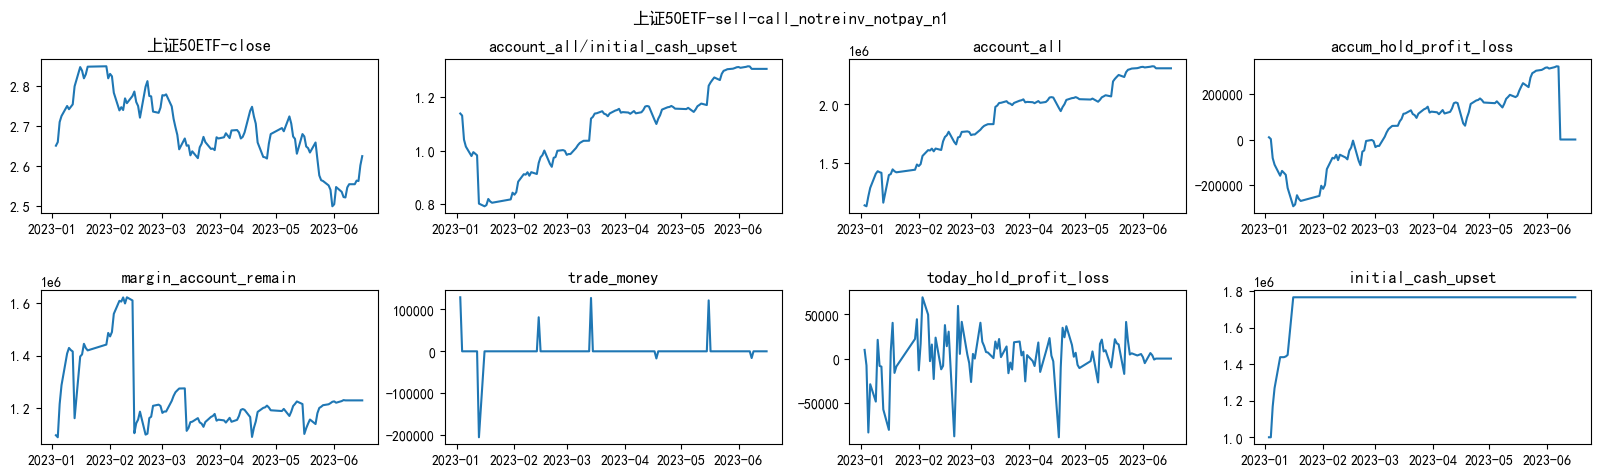

In [82]:
fig, axs = plt.subplots(2, 4, figsize=(20,5))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
dates = call_notreinv_notpay_n1['date']
axs[0, 0].plot(underlying_info['trade_date'], underlying_info['close'])
axs[0, 0].set_title('上证50ETF-close')
axs[0, 1].plot(dates, call_notreinv_notpay_n1['account_all']/call_notreinv_notpay_n1['initial_cash_upset'])
axs[0, 1].set_title('account_all/initial_cash_upset')
axs[0, 2].plot(dates, call_notreinv_notpay_n1['account_all'])
axs[0, 2].set_title('account_all')
axs[0, 3].plot(dates, call_notreinv_notpay_n1['accum_hold_profit_loss'])
axs[0, 3].set_title('accum_hold_profit_loss')
axs[1, 0].plot(dates, call_notreinv_notpay_n1['margin_account_remain'])
axs[1, 0].set_title('margin_account_remain')
axs[1, 1].plot(dates, call_notreinv_notpay_n1['trade_money'])
axs[1, 1].set_title('trade_money')
axs[1, 2].plot(dates, call_notreinv_notpay_n1['today_hold_profit_loss'])
axs[1, 2].set_title('today_hold_profit_loss')
axs[1, 3].plot(dates, call_notreinv_notpay_n1['initial_cash_upset'])
axs[1, 3].set_title('initial_cash_upset')
fig.suptitle('上证50ETF-sell-call_notreinv_notpay_n1')

#### 2.2  call & not_reinvest & is_pay & n=1

In [30]:
hold_record = None
call_notreinv_ispay_n1 = pd.DataFrame(columns=['date', 'hold_option', 'hold_option_amount', 
                                     'opt_remain_term', 'trade_money', 'today_hold_profit_loss', 
                                     'accum_hold_profit_loss', 'margin_account_remain', 
                                     'additional_cash', 'initial_cash_upset', 
                                     'account_all', 'flag'])
# 回测程序
t0 = time.time()
for i,j in enumerate(back_test_date):
    date = j
    hold_record = get_daily_recordf(underlying_code, date, end_date, option_type_call, 
                                   is_index, initial_cash, buffer, not_reinvest, n1, 
                                   hold_record=hold_record, bail_adjust=bail_adjust, 
                                   min_bail=min_bail, is_pay = is_pay)
    # print(hold_record)
    flag = hold_record[-1]
    if flag == False:
        call_notreinv_ispay_n1.loc[i] = hold_record
        break
    call_notreinv_ispay_n1.loc[i] = hold_record

t1 = time.time()
t = t1-t0    
t

17.50774836540222

In [31]:
# call_notreinv_notpay_n1.head()
call_notreinv_ispay_n1.to_csv('/root/jupyter/jupyter/卖权回测-final/call_notreinv_ispay_n1.csv' , index=False)

Text(0.5, 0.98, '上证50ETF-sell-call_notreinv_ispay_n1')

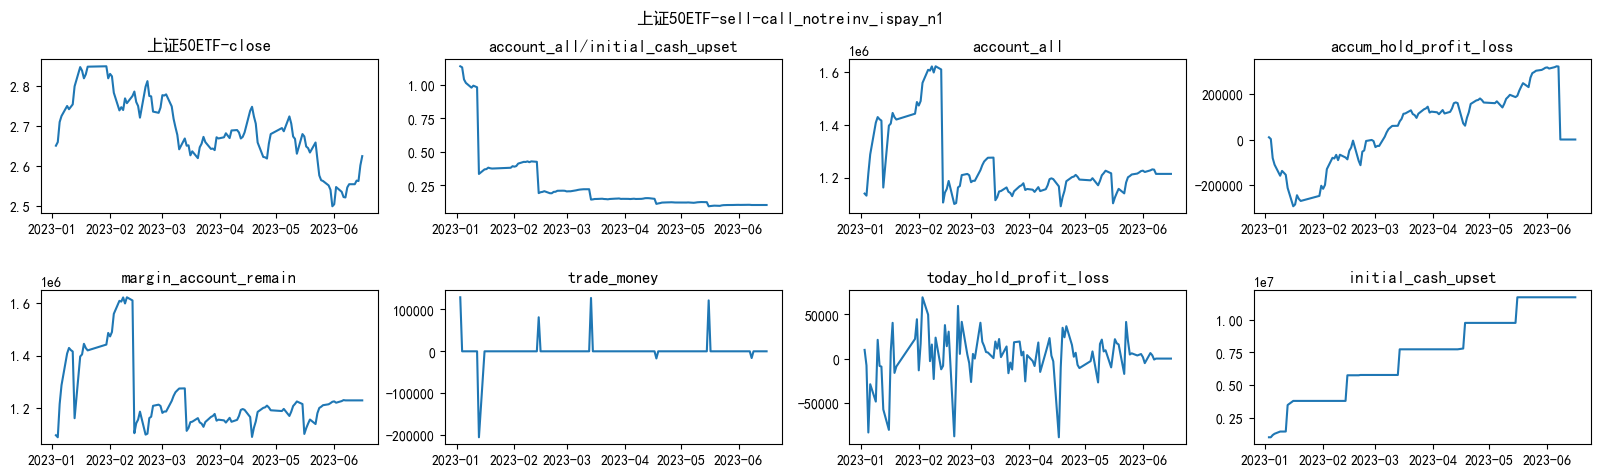

In [83]:
fig, axs = plt.subplots(2, 4, figsize=(20,5))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
dates = call_notreinv_ispay_n1['date']
axs[0, 0].plot(underlying_info['trade_date'], underlying_info['close'])
axs[0, 0].set_title('上证50ETF-close')
axs[0, 1].plot(dates, call_notreinv_ispay_n1['account_all']/call_notreinv_ispay_n1['initial_cash_upset'])
axs[0, 1].set_title('account_all/initial_cash_upset')
axs[0, 2].plot(dates, call_notreinv_ispay_n1['account_all'])
axs[0, 2].set_title('account_all')
axs[0, 3].plot(dates, call_notreinv_ispay_n1['accum_hold_profit_loss'])
axs[0, 3].set_title('accum_hold_profit_loss')
axs[1, 0].plot(dates, call_notreinv_ispay_n1['margin_account_remain'])
axs[1, 0].set_title('margin_account_remain')
axs[1, 1].plot(dates, call_notreinv_ispay_n1['trade_money'])
axs[1, 1].set_title('trade_money')
axs[1, 2].plot(dates, call_notreinv_ispay_n1['today_hold_profit_loss'])
axs[1, 2].set_title('today_hold_profit_loss')
axs[1, 3].plot(dates, call_notreinv_ispay_n1['initial_cash_upset'])
axs[1, 3].set_title('initial_cash_upset')
fig.suptitle('上证50ETF-sell-call_notreinv_ispay_n1')

#### 2.3  call & is_reinvest & not_pay & n=1

In [33]:
hold_record = None
call_isreinv_notpay_n1 = pd.DataFrame(columns=['date', 'hold_option', 'hold_option_amount', 
                                     'opt_remain_term', 'trade_money', 'today_hold_profit_loss', 
                                     'accum_hold_profit_loss', 'margin_account_remain', 
                                     'additional_cash', 'initial_cash_upset', 
                                     'account_all', 'flag'])

# 回测程序
t0 = time.time()
for i,j in enumerate(back_test_date):
    date = j
    hold_record = get_daily_recordf(underlying_code, date, end_date, option_type_call, 
                                   is_index, initial_cash, buffer, is_reinvest, n1, 
                                   hold_record=hold_record, bail_adjust=bail_adjust, 
                                   min_bail=min_bail, is_pay = not_pay)
    # print(hold_record)
    flag = hold_record[-1]
    if flag == False:
        call_isreinv_notpay_n1.loc[i] = hold_record
        break
    call_isreinv_notpay_n1.loc[i] = hold_record

t1 = time.time()
t = t1-t0    
t

17.865248441696167

In [34]:
# call_notreinv_notpay_n1.head()
call_isreinv_notpay_n1.to_csv('/root/jupyter/jupyter/卖权回测-final/call_isreinv_notpay_n1.csv' , index=False)

Text(0.5, 0.98, '上证50ETF-sell-call_isreinv_notpay_n1')

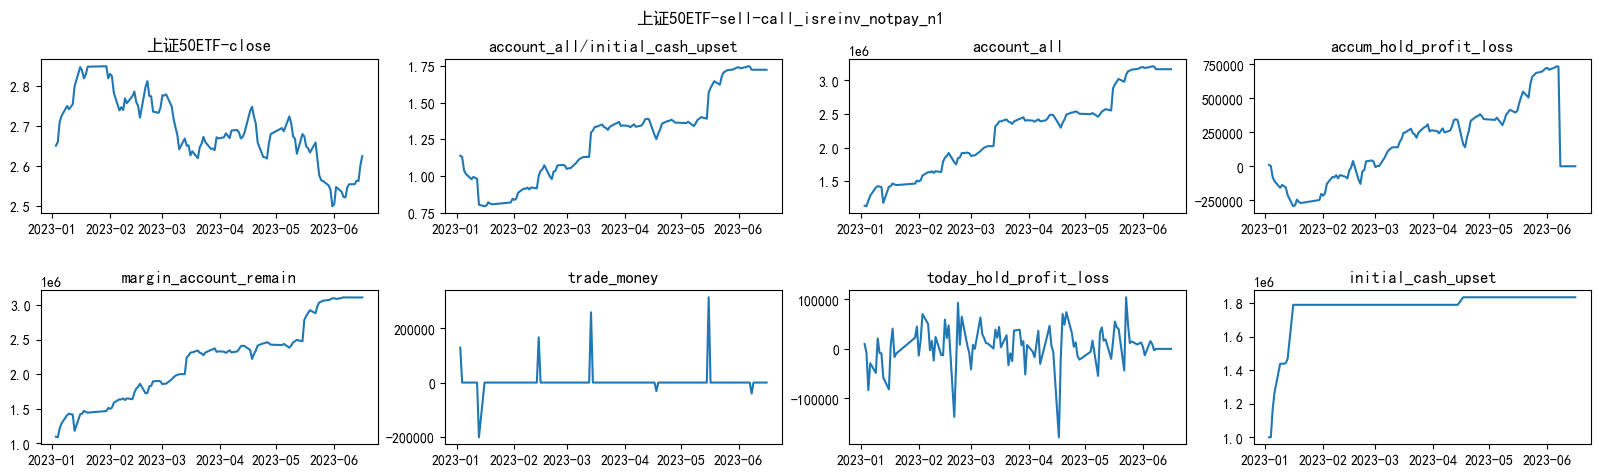

In [84]:
fig, axs = plt.subplots(2, 4, figsize=(20,5))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
dates = call_isreinv_notpay_n1['date']
axs[0, 0].plot(underlying_info['trade_date'], underlying_info['close'])
axs[0, 0].set_title('上证50ETF-close')
axs[0, 1].plot(dates, call_isreinv_notpay_n1['account_all']/call_isreinv_notpay_n1['initial_cash_upset'])
axs[0, 1].set_title('account_all/initial_cash_upset')
axs[0, 2].plot(dates, call_isreinv_notpay_n1['account_all'])
axs[0, 2].set_title('account_all')
axs[0, 3].plot(dates, call_isreinv_notpay_n1['accum_hold_profit_loss'])
axs[0, 3].set_title('accum_hold_profit_loss')
axs[1, 0].plot(dates, call_isreinv_notpay_n1['margin_account_remain'])
axs[1, 0].set_title('margin_account_remain')
axs[1, 1].plot(dates, call_isreinv_notpay_n1['trade_money'])
axs[1, 1].set_title('trade_money')
axs[1, 2].plot(dates, call_isreinv_notpay_n1['today_hold_profit_loss'])
axs[1, 2].set_title('today_hold_profit_loss')
axs[1, 3].plot(dates, call_isreinv_notpay_n1['initial_cash_upset'])
axs[1, 3].set_title('initial_cash_upset')
fig.suptitle('上证50ETF-sell-call_isreinv_notpay_n1')

#### 2.4  call & not_reinvest & not_pay & n=2

In [36]:
hold_record = None
call_notreinv_notpay_n2 = pd.DataFrame(columns=['date', 'hold_option', 'hold_option_amount', 
                                     'opt_remain_term', 'trade_money', 'today_hold_profit_loss', 
                                     'accum_hold_profit_loss', 'margin_account_remain', 
                                     'additional_cash', 'initial_cash_upset', 
                                     'account_all', 'flag'])

# 回测程序
t0 = time.time()
for i,j in enumerate(back_test_date):
    date = j
    hold_record = get_daily_recordf(underlying_code, date, end_date, option_type_call, 
                                   is_index, initial_cash, buffer, not_reinvest, n2, 
                                   hold_record=hold_record, bail_adjust=bail_adjust, 
                                   min_bail=min_bail, is_pay = not_pay)
    # print(hold_record)
    flag = hold_record[-1]
    if flag == False:
        call_notreinv_notpay_n2.loc[i] = hold_record
        break
    call_notreinv_notpay_n2.loc[i] = hold_record

t1 = time.time()
t = t1-t0    
t

17.949321746826172

In [37]:
# call_notreinv_notpay_n1.head()
call_notreinv_notpay_n2.to_csv('/root/jupyter/jupyter/卖权回测-final/call_notreinv_notpay_n2.csv' , index=False)

Text(0.5, 0.98, '上证50ETF-sell-call_notreinv_notpay_n2')

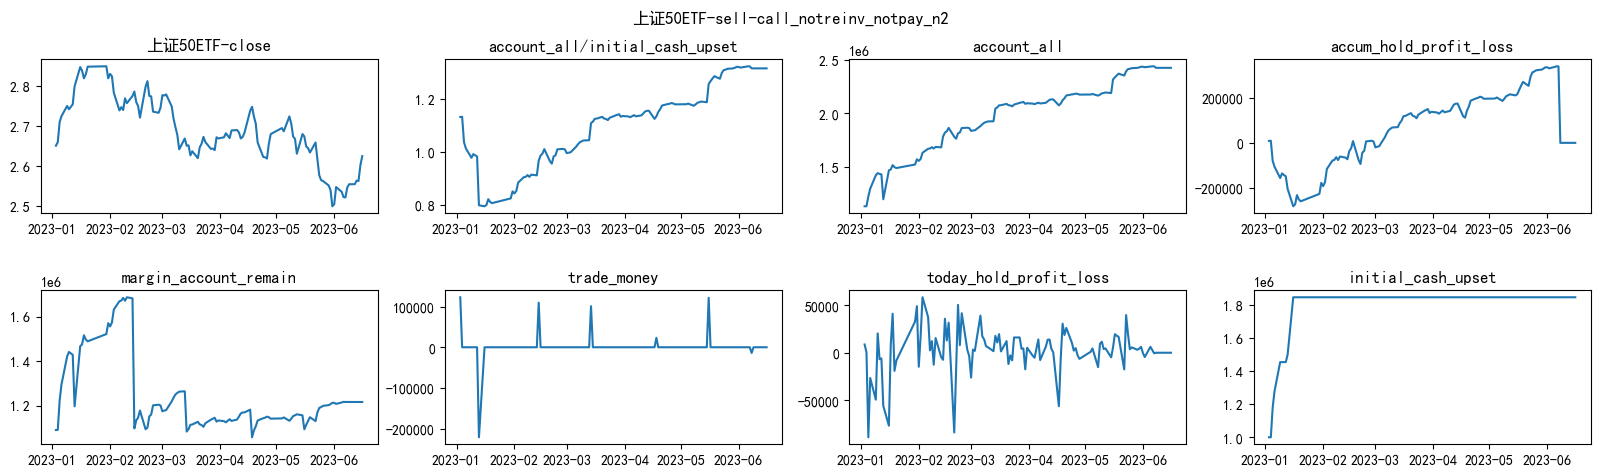

In [85]:
fig, axs = plt.subplots(2, 4, figsize=(20,5))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
dates = call_notreinv_notpay_n2['date']
axs[0, 0].plot(underlying_info['trade_date'], underlying_info['close'])
axs[0, 0].set_title('上证50ETF-close')
axs[0, 1].plot(dates, call_notreinv_notpay_n2['account_all']/call_notreinv_notpay_n2['initial_cash_upset'])
axs[0, 1].set_title('account_all/initial_cash_upset')
axs[0, 2].plot(dates, call_notreinv_notpay_n2['account_all'])
axs[0, 2].set_title('account_all')
axs[0, 3].plot(dates, call_notreinv_notpay_n2['accum_hold_profit_loss'])
axs[0, 3].set_title('accum_hold_profit_loss')
axs[1, 0].plot(dates, call_notreinv_notpay_n2['margin_account_remain'])
axs[1, 0].set_title('margin_account_remain')
axs[1, 1].plot(dates, call_notreinv_notpay_n2['trade_money'])
axs[1, 1].set_title('trade_money')
axs[1, 2].plot(dates, call_notreinv_notpay_n2['today_hold_profit_loss'])
axs[1, 2].set_title('today_hold_profit_loss')
axs[1, 3].plot(dates, call_notreinv_notpay_n2['initial_cash_upset'])
axs[1, 3].set_title('initial_cash_upset')
fig.suptitle('上证50ETF-sell-call_notreinv_notpay_n2')

#### 2.5  put & not_reinvest & not_pay & n=1

In [39]:
hold_record = None
put_notreinv_notpay_n1 = pd.DataFrame(columns=['date', 'hold_option', 'hold_option_amount', 
                                     'opt_remain_term', 'trade_money', 'today_hold_profit_loss', 
                                     'accum_hold_profit_loss', 'margin_account_remain', 
                                     'additional_cash', 'initial_cash_upset', 
                                     'account_all', 'flag'])

# 回测程序
t0 = time.time()
for i,j in enumerate(back_test_date):
    date = j
    hold_record = get_daily_recordf(underlying_code, date, end_date, option_type_put, 
                                   is_index, initial_cash, buffer, not_reinvest, n1, 
                                   hold_record=hold_record, bail_adjust=bail_adjust, 
                                   min_bail=min_bail, is_pay = not_pay)
    # print(hold_record)
    flag = hold_record[-1]
    if flag == False:
        put_notreinv_notpay_n1.loc[i] = hold_record
        break
    put_notreinv_notpay_n1.loc[i] = hold_record

t1 = time.time()
t = t1-t0    
t

19.829638242721558

In [40]:
# call_notreinv_notpay_n1.head()
put_notreinv_notpay_n1.to_csv('/root/jupyter/jupyter/卖权回测-final/put_notreinv_notpay_n1.csv' , index=False)

Text(0.5, 0.98, '上证50ETF-sell-put_notreinv_notpay_n1')

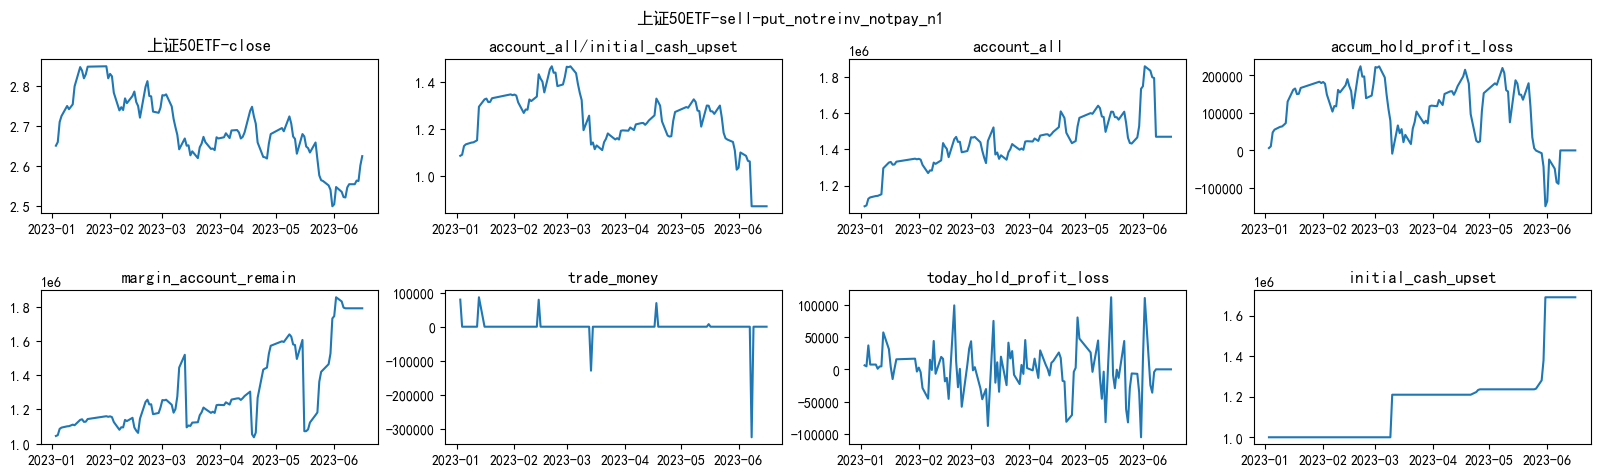

In [86]:
fig, axs = plt.subplots(2, 4, figsize=(20,5))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
dates = put_notreinv_notpay_n1['date']
axs[0, 0].plot(underlying_info['trade_date'], underlying_info['close'])
axs[0, 0].set_title('上证50ETF-close')
axs[0, 1].plot(dates, put_notreinv_notpay_n1['account_all']/put_notreinv_notpay_n1['initial_cash_upset'])
axs[0, 1].set_title('account_all/initial_cash_upset')
axs[0, 2].plot(dates, put_notreinv_notpay_n1['account_all'])
axs[0, 2].set_title('account_all')
axs[0, 3].plot(dates, put_notreinv_notpay_n1['accum_hold_profit_loss'])
axs[0, 3].set_title('accum_hold_profit_loss')
axs[1, 0].plot(dates, put_notreinv_notpay_n1['margin_account_remain'])
axs[1, 0].set_title('margin_account_remain')
axs[1, 1].plot(dates, put_notreinv_notpay_n1['trade_money'])
axs[1, 1].set_title('trade_money')
axs[1, 2].plot(dates, put_notreinv_notpay_n1['today_hold_profit_loss'])
axs[1, 2].set_title('today_hold_profit_loss')
axs[1, 3].plot(dates, put_notreinv_notpay_n1['initial_cash_upset'])
axs[1, 3].set_title('initial_cash_upset')
fig.suptitle('上证50ETF-sell-put_notreinv_notpay_n1')

#### 2.6  put & not_reinvest & is_pay & n=1

In [42]:
hold_record = None
put_notreinv_ispay_n1 = pd.DataFrame(columns=['date', 'hold_option', 'hold_option_amount', 
                                     'opt_remain_term', 'trade_money', 'today_hold_profit_loss', 
                                     'accum_hold_profit_loss', 'margin_account_remain', 
                                     'additional_cash', 'initial_cash_upset', 
                                     'account_all', 'flag'])
# 回测程序
t0 = time.time()
for i,j in enumerate(back_test_date):
    date = j
    hold_record = get_daily_recordf(underlying_code, date, end_date, option_type_put, 
                                   is_index, initial_cash, buffer, not_reinvest, n1, 
                                   hold_record=hold_record, bail_adjust=bail_adjust, 
                                   min_bail=min_bail, is_pay = is_pay)
    # print(hold_record)
    flag = hold_record[-1]
    if flag == False:
        put_notreinv_ispay_n1.loc[i] = hold_record
        break
    put_notreinv_ispay_n1.loc[i] = hold_record

t1 = time.time()
t = t1-t0    
t

18.62363338470459

In [43]:
# call_notreinv_notpay_n1.head()
put_notreinv_ispay_n1.to_csv('/root/jupyter/jupyter/卖权回测-final/put_notreinv_ispay_n1.csv' , index=False)

Text(0.5, 0.98, '上证50ETF-sell-put_notreinv_ispay_n1')

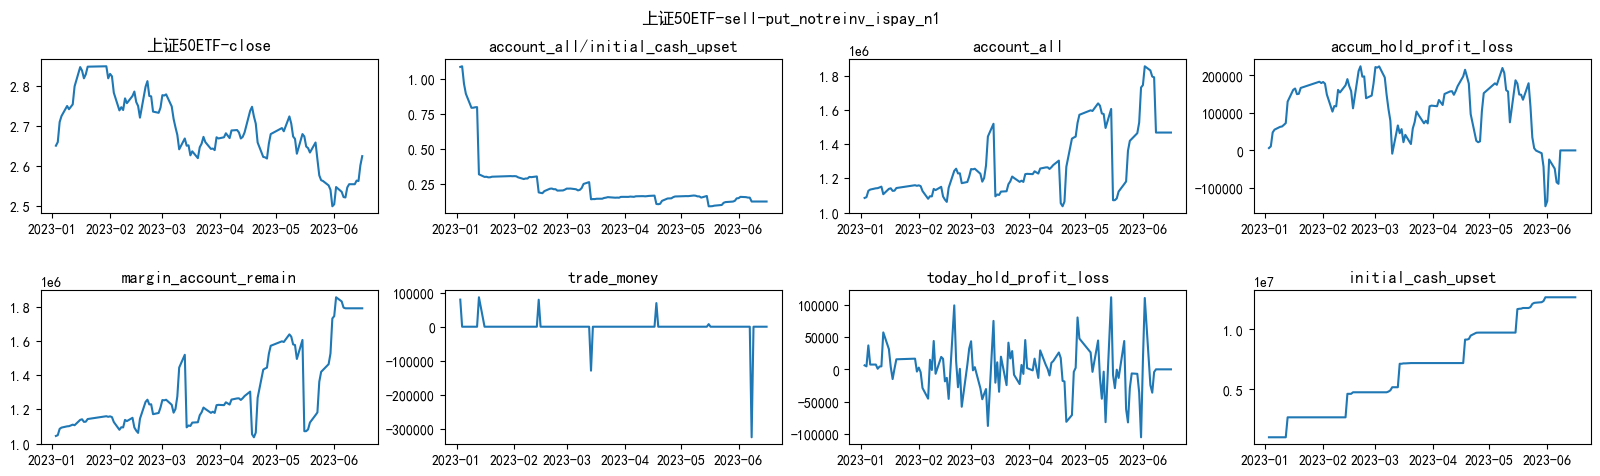

In [87]:
fig, axs = plt.subplots(2, 4, figsize=(20,5))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
dates = put_notreinv_ispay_n1['date']
axs[0, 0].plot(underlying_info['trade_date'], underlying_info['close'])
axs[0, 0].set_title('上证50ETF-close')
axs[0, 1].plot(dates, put_notreinv_ispay_n1['account_all']/call_notreinv_ispay_n1['initial_cash_upset'])
axs[0, 1].set_title('account_all/initial_cash_upset')
axs[0, 2].plot(dates, put_notreinv_ispay_n1['account_all'])
axs[0, 2].set_title('account_all')
axs[0, 3].plot(dates, put_notreinv_ispay_n1['accum_hold_profit_loss'])
axs[0, 3].set_title('accum_hold_profit_loss')
axs[1, 0].plot(dates, put_notreinv_ispay_n1['margin_account_remain'])
axs[1, 0].set_title('margin_account_remain')
axs[1, 1].plot(dates, put_notreinv_ispay_n1['trade_money'])
axs[1, 1].set_title('trade_money')
axs[1, 2].plot(dates, put_notreinv_ispay_n1['today_hold_profit_loss'])
axs[1, 2].set_title('today_hold_profit_loss')
axs[1, 3].plot(dates, put_notreinv_ispay_n1['initial_cash_upset'])
axs[1, 3].set_title('initial_cash_upset')
fig.suptitle('上证50ETF-sell-put_notreinv_ispay_n1')

#### 2.7  put & is_reinvest & not_pay & n=1

In [45]:
hold_record = None
put_isreinv_notpay_n1 = pd.DataFrame(columns=['date', 'hold_option', 'hold_option_amount', 
                                     'opt_remain_term', 'trade_money', 'today_hold_profit_loss', 
                                     'accum_hold_profit_loss', 'margin_account_remain', 
                                     'additional_cash', 'initial_cash_upset', 
                                     'account_all', 'flag'])

# 回测程序
t0 = time.time()
for i,j in enumerate(back_test_date):
    date = j
    hold_record = get_daily_recordf(underlying_code, date, end_date, option_type_put, 
                                   is_index, initial_cash, buffer, is_reinvest, n1, 
                                   hold_record=hold_record, bail_adjust=bail_adjust, 
                                   min_bail=min_bail, is_pay = not_pay)
    # print(hold_record)
    flag = hold_record[-1]
    if flag == False:
        put_isreinv_notpay_n1.loc[i] = hold_record
        break
    put_isreinv_notpay_n1.loc[i] = hold_record

t1 = time.time()
t = t1-t0    
t

20.024336576461792

In [46]:
# call_notreinv_notpay_n1.head()
put_isreinv_notpay_n1.to_csv('/root/jupyter/jupyter/卖权回测-final/put_isreinv_notpay_n1.csv' , index=False)

Text(0.5, 0.98, '上证50ETF-sell-call_isreinv_notpay_n1')

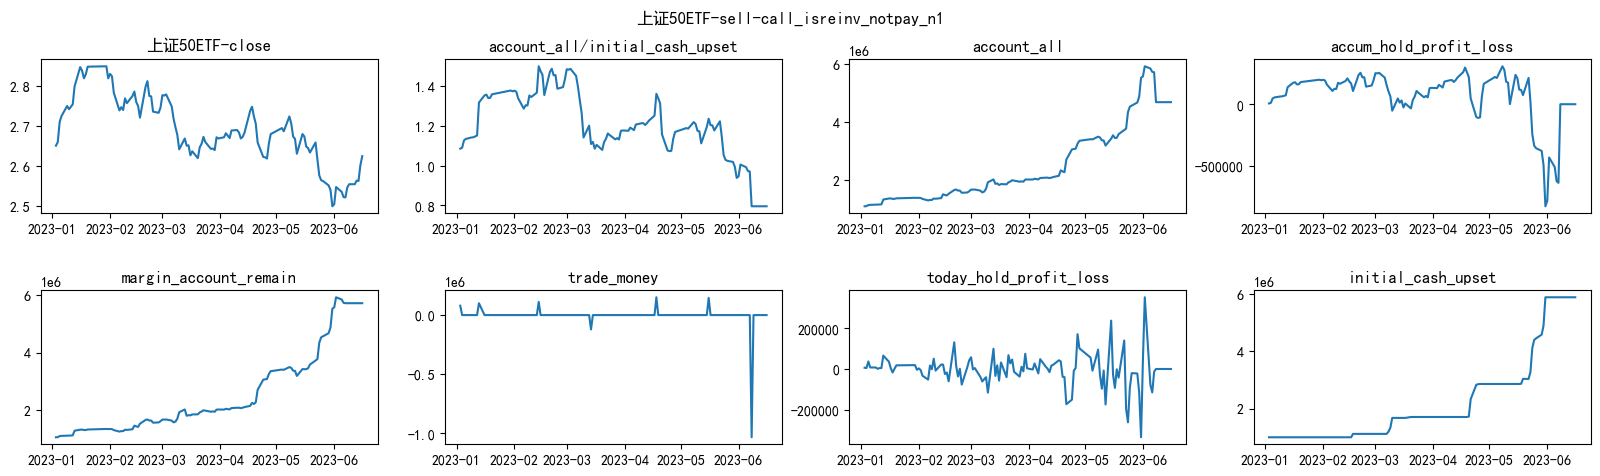

In [88]:
fig, axs = plt.subplots(2, 4, figsize=(20,5))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
dates = put_isreinv_notpay_n1['date']
axs[0, 0].plot(underlying_info['trade_date'], underlying_info['close'])
axs[0, 0].set_title('上证50ETF-close')
axs[0, 1].plot(dates, put_isreinv_notpay_n1['account_all']/put_isreinv_notpay_n1['initial_cash_upset'])
axs[0, 1].set_title('account_all/initial_cash_upset')
axs[0, 2].plot(dates, put_isreinv_notpay_n1['account_all'])
axs[0, 2].set_title('account_all')
axs[0, 3].plot(dates, put_isreinv_notpay_n1['accum_hold_profit_loss'])
axs[0, 3].set_title('accum_hold_profit_loss')
axs[1, 0].plot(dates, put_isreinv_notpay_n1['margin_account_remain'])
axs[1, 0].set_title('margin_account_remain')
axs[1, 1].plot(dates, put_isreinv_notpay_n1['trade_money'])
axs[1, 1].set_title('trade_money')
axs[1, 2].plot(dates, put_isreinv_notpay_n1['today_hold_profit_loss'])
axs[1, 2].set_title('today_hold_profit_loss')
axs[1, 3].plot(dates, put_isreinv_notpay_n1['initial_cash_upset'])
axs[1, 3].set_title('initial_cash_upset')
fig.suptitle('上证50ETF-sell-call_isreinv_notpay_n1')

#### 2.8  put & not_reinvest & not_pay & n=2

In [48]:
hold_record = None
put_notreinv_notpay_n2 = pd.DataFrame(columns=['date', 'hold_option', 'hold_option_amount', 
                                     'opt_remain_term', 'trade_money', 'today_hold_profit_loss', 
                                     'accum_hold_profit_loss', 'margin_account_remain', 
                                     'additional_cash', 'initial_cash_upset', 
                                     'account_all', 'flag'])

# 回测程序
t0 = time.time()
for i,j in enumerate(back_test_date):
    date = j
    hold_record = get_daily_recordf(underlying_code, date, end_date, option_type_put, 
                                   is_index, initial_cash, buffer, not_reinvest, n2, 
                                   hold_record=hold_record, bail_adjust=bail_adjust, 
                                   min_bail=min_bail, is_pay = not_pay)
    # print(hold_record)
    flag = hold_record[-1]
    if flag == False:
        put_notreinv_notpay_n2.loc[i] = hold_record
        break
    put_notreinv_notpay_n2.loc[i] = hold_record

t1 = time.time()
t = t1-t0    
t

20.094679594039917

In [49]:
# call_notreinv_notpay_n1.head()
put_notreinv_notpay_n2.to_csv('/root/jupyter/jupyter/卖权回测-final/put_notreinv_notpay_n2.csv' , index=False)

Text(0.5, 0.98, '上证50ETF-sell-put_notreinv_notpay_n2')

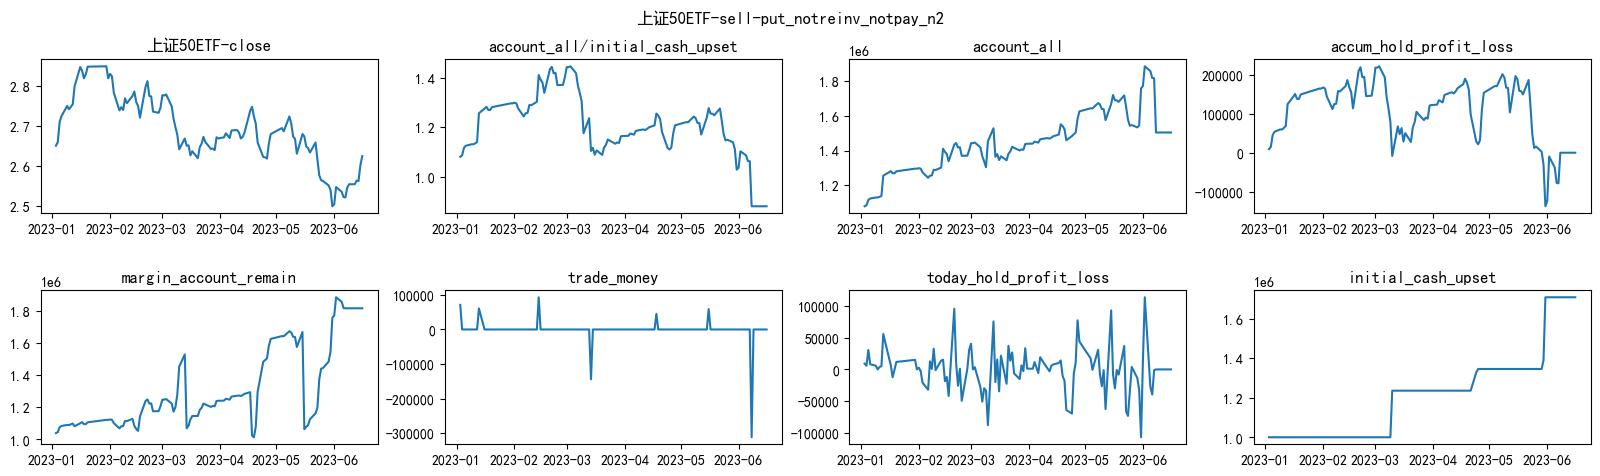

In [89]:
fig, axs = plt.subplots(2, 4, figsize=(20,5))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
dates = put_notreinv_notpay_n2['date']
axs[0, 0].plot(underlying_info['trade_date'], underlying_info['close'])
axs[0, 0].set_title('上证50ETF-close')
axs[0, 1].plot(dates, put_notreinv_notpay_n2['account_all']/put_notreinv_notpay_n2['initial_cash_upset'])
axs[0, 1].set_title('account_all/initial_cash_upset')
axs[0, 2].plot(dates, put_notreinv_notpay_n2['account_all'])
axs[0, 2].set_title('account_all')
axs[0, 3].plot(dates, put_notreinv_notpay_n2['accum_hold_profit_loss'])
axs[0, 3].set_title('accum_hold_profit_loss')
axs[1, 0].plot(dates, put_notreinv_notpay_n2['margin_account_remain'])
axs[1, 0].set_title('margin_account_remain')
axs[1, 1].plot(dates, put_notreinv_notpay_n2['trade_money'])
axs[1, 1].set_title('trade_money')
axs[1, 2].plot(dates, put_notreinv_notpay_n2['today_hold_profit_loss'])
axs[1, 2].set_title('today_hold_profit_loss')
axs[1, 3].plot(dates, put_notreinv_notpay_n2['initial_cash_upset'])
axs[1, 3].set_title('initial_cash_upset')
fig.suptitle('上证50ETF-sell-put_notreinv_notpay_n2')

### 3. 汇总展示

#### 3.1  上证50ETF-close

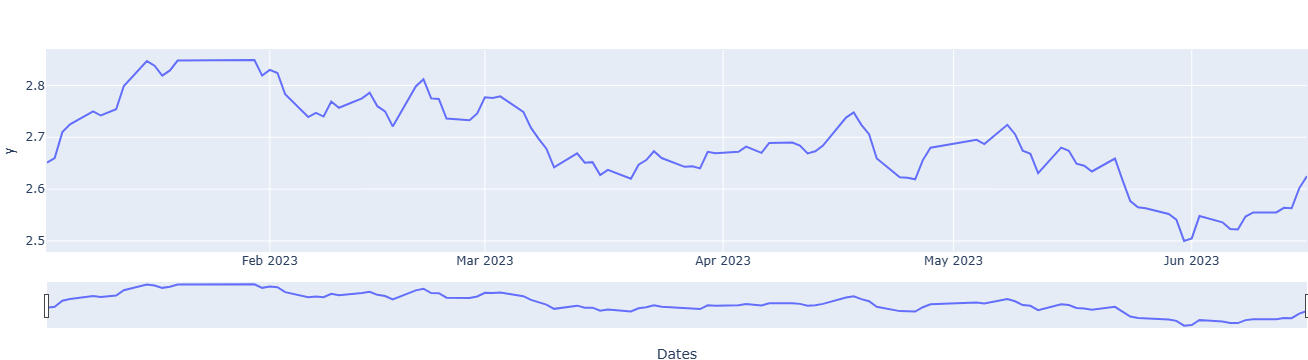

In [181]:
fig = px.line(x=underlying_info['trade_date'], y=underlying_info['close'])
fig.update_layout(xaxis_title = 'Dates', autosize=False, width=1100, height=300, margin=dict(l=1, r=1, b=1, t=50, pad=1))
fig.update_xaxes(rangeslider_visible=True) # 调节区间
fig.show()

#### 3.2  account_all/initial_cash_upset

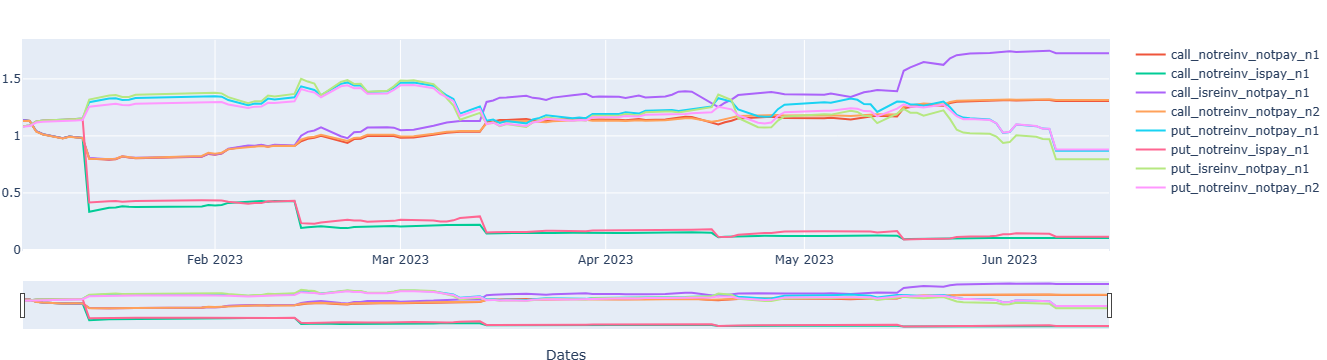

In [189]:
fig = px.line()
fig.add_scatter(x=dates, y=call_notreinv_notpay_n1['account_all']/call_notreinv_notpay_n1['initial_cash_upset'], name= 'call_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_ispay_n1['account_all']/call_notreinv_ispay_n1['initial_cash_upset'], name= 'call_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=call_isreinv_notpay_n1['account_all']/call_isreinv_notpay_n1['initial_cash_upset'], name= 'call_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_notpay_n2['account_all']/call_notreinv_notpay_n2['initial_cash_upset'], name= 'call_notreinv_notpay_n2')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n1['account_all']/put_notreinv_notpay_n1['initial_cash_upset'], name= 'put_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_ispay_n1['account_all']/put_notreinv_ispay_n1['initial_cash_upset'], name= 'put_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=put_isreinv_notpay_n1['account_all']/put_isreinv_notpay_n1['initial_cash_upset'], name= 'put_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n2['account_all']/put_notreinv_notpay_n2['initial_cash_upset'], name= 'put_notreinv_notpay_n2')
fig.update_xaxes(rangeslider_visible=True) # 调节区间
fig.update_layout(xaxis_title = 'Dates', autosize=False, width=1300, height=300, margin=dict(l=1, r=1, b=1, t=40, pad=1))
fig.show()

#### 3.3  account_all

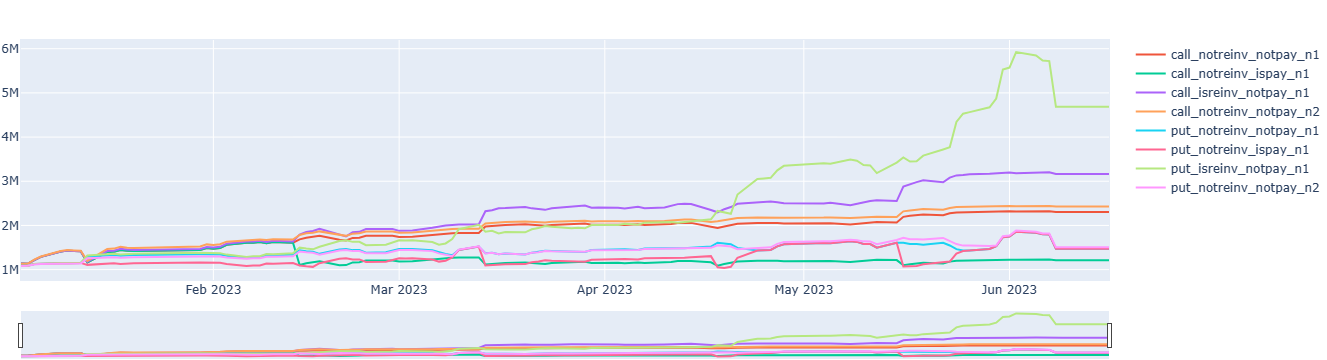

In [190]:
fig = px.line()
fig.add_scatter(x=dates, y=call_notreinv_notpay_n1['account_all'], name= 'call_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_ispay_n1['account_all'], name= 'call_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=call_isreinv_notpay_n1['account_all'], name= 'call_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_notpay_n2['account_all'], name= 'call_notreinv_notpay_n2')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n1['account_all'], name= 'put_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_ispay_n1['account_all'], name= 'put_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=put_isreinv_notpay_n1['account_all'], name= 'put_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n2['account_all'], name= 'put_notreinv_notpay_n2')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(autosize=False, width=1300, height=300, margin=dict(l=1, r=1, b=1, t=40, pad=1))
fig.show()

#### 3.4  initial_cash_upset

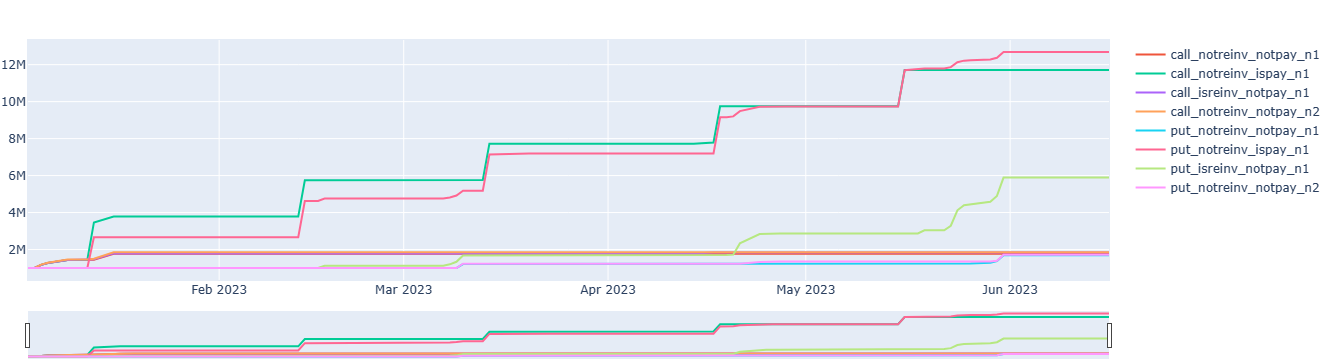

In [191]:
fig = px.line()
fig.add_scatter(x=dates, y=call_notreinv_notpay_n1['initial_cash_upset'], name= 'call_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_ispay_n1['initial_cash_upset'], name= 'call_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=call_isreinv_notpay_n1['initial_cash_upset'], name= 'call_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_notpay_n2['initial_cash_upset'], name= 'call_notreinv_notpay_n2')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n1['initial_cash_upset'], name= 'put_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_ispay_n1['initial_cash_upset'], name= 'put_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=put_isreinv_notpay_n1['initial_cash_upset'], name= 'put_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n2['initial_cash_upset'], name= 'put_notreinv_notpay_n2')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(autosize=False, width=1300, height=300, margin=dict(l=1, r=1, b=1, t=40, pad=1))
fig.show()

#### 3.5 accum_hold_profit_loss

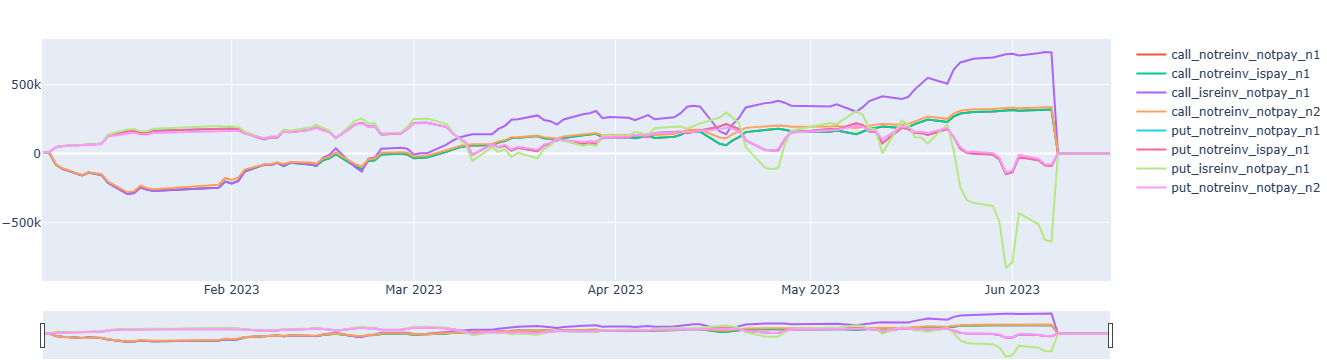

In [192]:
fig = px.line()
fig.add_scatter(x=dates, y=call_notreinv_notpay_n1['accum_hold_profit_loss'], name= 'call_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_ispay_n1['accum_hold_profit_loss'], name= 'call_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=call_isreinv_notpay_n1['accum_hold_profit_loss'], name= 'call_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_notpay_n2['accum_hold_profit_loss'], name= 'call_notreinv_notpay_n2')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n1['accum_hold_profit_loss'], name= 'put_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_ispay_n1['accum_hold_profit_loss'], name= 'put_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=put_isreinv_notpay_n1['accum_hold_profit_loss'], name= 'put_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n2['accum_hold_profit_loss'], name= 'put_notreinv_notpay_n2')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(autosize=False, width=1300, height=300, margin=dict(l=1, r=1, b=1, t=40, pad=1))
fig.show()

#### 3.6 trade_money

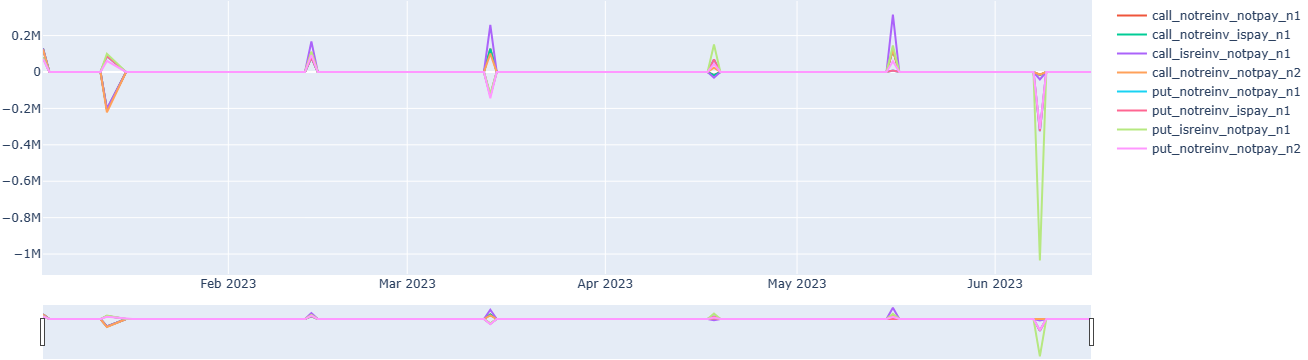

In [193]:
fig = px.line()
fig.add_scatter(x=dates, y=call_notreinv_notpay_n1['trade_money'], name= 'call_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_ispay_n1['trade_money'], name= 'call_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=call_isreinv_notpay_n1['trade_money'], name= 'call_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_notpay_n2['trade_money'], name= 'call_notreinv_notpay_n2')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n1['trade_money'], name= 'put_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_ispay_n1['trade_money'], name= 'put_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=put_isreinv_notpay_n1['trade_money'], name= 'put_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n2['trade_money'], name= 'put_notreinv_notpay_n2')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(autosize=False, width=1300, height=300, margin=dict(l=1, r=1, b=1, t=1, pad=1))
fig.show()

#### 3.7 margin_account_remain

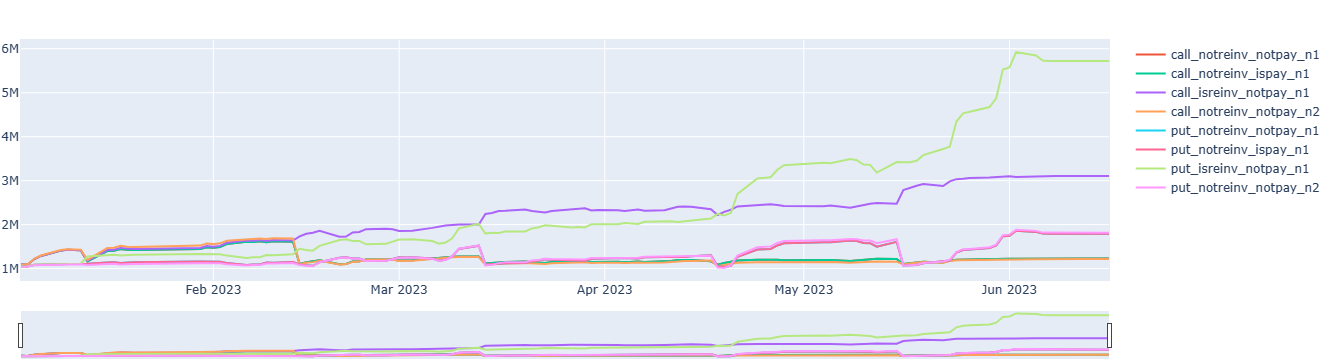

In [188]:
fig = px.line()
fig.add_scatter(x=dates, y=call_notreinv_notpay_n1['margin_account_remain'], name= 'call_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_ispay_n1['margin_account_remain'], name= 'call_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=call_isreinv_notpay_n1['margin_account_remain'], name= 'call_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_notpay_n2['margin_account_remain'], name= 'call_notreinv_notpay_n2')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n1['margin_account_remain'], name= 'put_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_ispay_n1['margin_account_remain'], name= 'put_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=put_isreinv_notpay_n1['margin_account_remain'], name= 'put_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n2['margin_account_remain'], name= 'put_notreinv_notpay_n2')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(autosize=False, width=1300, height=300, margin=dict(l=1, r=1, b=1, t=40, pad=1))
fig.show()

#### 3.8 today_hold_profit_loss

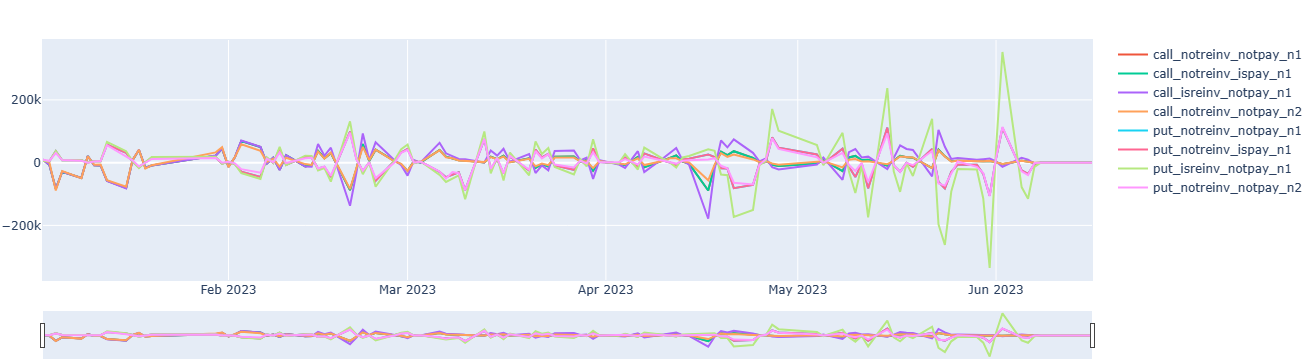

In [187]:
fig = px.line()
fig.add_scatter(x=dates, y=call_notreinv_notpay_n1['today_hold_profit_loss'], name= 'call_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_ispay_n1['today_hold_profit_loss'], name= 'call_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=call_isreinv_notpay_n1['today_hold_profit_loss'], name= 'call_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=call_notreinv_notpay_n2['today_hold_profit_loss'], name= 'call_notreinv_notpay_n2')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n1['today_hold_profit_loss'], name= 'put_notreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_ispay_n1['today_hold_profit_loss'], name= 'put_notreinv_ispay_n1')
fig.add_scatter(x=dates, y=put_isreinv_notpay_n1['today_hold_profit_loss'], name= 'put_isreinv_notpay_n1')
fig.add_scatter(x=dates, y=put_notreinv_notpay_n2['today_hold_profit_loss'], name= 'put_notreinv_notpay_n2')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(autosize=False, width=1300, height=300, margin=dict(l=1, r=1, b=1, t=40, pad=1))
fig.show()